This script contains the code to filter the sequences used for modeling and align them. Since I ran this script multiple times (one for each raster resolution), I've archived the notebooks in various formats at each resolution in the "script_archive_publication" folder, including the date when I ran them.

Load packages

In [356]:
suppressMessages(library(data.table))
suppressMessages(library(sf))
suppressMessages(library(raster))
suppressMessages(library(gdata))
suppressMessages(library(rnaturalearth))
suppressMessages(library(seqinr))
suppressMessages(library(furrr))
suppressMessages(library(here))
suppressMessages(library(tidyverse))
suppressMessages(library(tictoc))

suppressMessages(source("R/equal_area_resampling.R")) # aggregate rasters

Specify raster resolution and create output folders. Results may differ across resolutions, so I'm testing three different resolutions: 100x100 km, 200x200 km, and 300x300 km. This script needs to be run for each different resolution.

In [357]:
# specify resolution
res <- 300

# function to check if subfolder exists. If not, make it
create_dir <- function(out_path) {
  if (!dir.exists(out_path)) {
    dir.create(out_path)
  } else
    print("Directory already there.")
}

# path for spreadsheet output
spread_path <- here::here("output", "spreadsheets")

create_dir(spread_path)

# path for unaligned fastas
fasta_path <- here::here("output", paste0("fastas_", res))

create_dir(fasta_path)

# path for aligned fastas
align_path <- here::here("output", paste0("alignments_", res))

create_dir(align_path)


[1] "Directory already there."


Read in data. Separate the data into a metadata dataframe and a sequence data frame to make filtering faster. Only keep records that contain coordinates, bin_uri identifiers, and are COI sequences.

**Important columns**: recordID, bin_uri, order_taxID, order_name, family_taxID, family_name, subfamily_taxID, subfamily_name, genus_taxID, genus_name, species_taxID, species_name, collectiondate_start, collectiondate_end, habitat, lat, lon, coord_accuracy, elev, elev_accuracy, depth, country, province_state, region, sequenceID, markercode, genbank_accession, nucleotides, seq_primers, marker_codes    

In [358]:
bold_meta <- fread(here("data", "bold_data_insects.txt"), 
        na.strings = c("", "NA"),
        quote = "",
        select = c(
            "recordID", 
            "bin_uri", 
            "order_taxID", 
            "order_name", 
            "family_taxID", 
            "family_name", 
            "subfamily_taxID", 
            "subfamily_name", 
            "genus_taxID", 
            "genus_name", 
            "species_taxID", 
            "species_name", 
            "collectiondate_start", 
            "collectiondate_end", 
            "habitat", 
            "lat", 
            "lon", 
            "coord_accuracy", 
            "elev", 
            "elev_accuracy", 
            "depth", 
            "country", 
            "province_state", 
            "region", 
            "sequenceID", 
            "markercode", 
            "genbank_accession",  
            "seq_primers", 
            "marker_codes"))[
    !is.na(lat) &
    !is.na(lon) &
    !is.na(bin_uri) &
    str_detect(markercode, "COI-5P")]


bold_seqs <- fread(here("data", "bold_data_insects.txt"), 
        na.strings = c("", "NA"),
        quote = "")[
    !is.na(lat) &
    !is.na(lon) &
    !is.na(bin_uri) &
    str_detect(markercode, "COI-5P"), .(recordID, nucleotides)]

paste0("Number of records in bold_meta without NAs: ", nrow(bold_meta))
paste0("Number of records in bold_seqs without NAs: ", nrow(bold_seqs))

[1] "Number of records in bold_meta without NAs: 3301025"

[1] "Number of records in bold_seqs without NAs: 3301025"

Get the proportion of missing data for each taxon level in the full data set.

In [359]:
taxa_na_table <- bold_meta[, .( order = sum(is.na(order_name)) / nrow(bold_meta),
                              family = sum(is.na(family_name)) / nrow(bold_meta),
                              subfamily = sum(is.na(subfamily_name)) / nrow(bold_meta),
                              genus = sum(is.na(genus_name)) / nrow(bold_meta), 
                              species = sum(is.na(species_name)) / nrow(bold_meta))]
taxa_na_table

order,family,subfamily,genus,species
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
6.846358e-05,0.2228941,0.416537,0.4165985,0.5747054


Get an idea of the distribution of sequence lengths in the data set. There are exceptionally long and short sequences, so we need to do something with those.

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  130.0   636.0   658.0   651.2   658.0  1560.0 

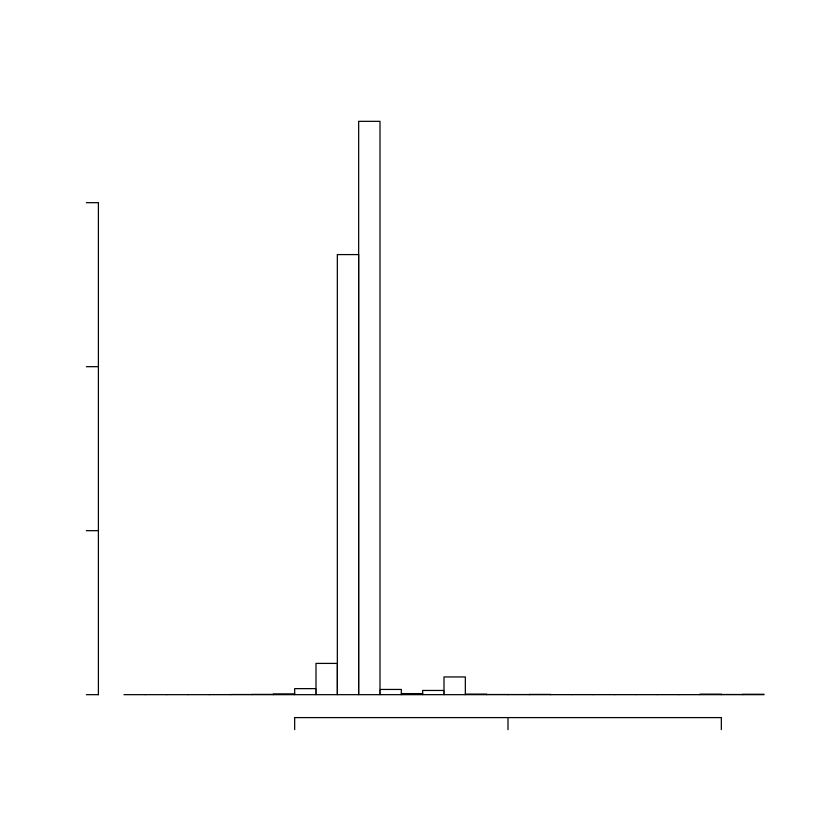

In [360]:
bold_seq_lengths <- bold_seqs[, n_nucs := str_length(nucleotides)]

bold_seq_lengths <- na.omit(bold_seq_lengths, cols = "n_nucs")

bold_seq_lengths %>% 
    select(recordID, n_nucs) %>% 
    fwrite(here("output", "spreadsheets", "bold_seq_lengths.csv"))


summary(bold_seq_lengths$n_nucs)
hist(bold_seq_lengths$n_nucs, xlab = "Sequence length")


Full taxon list

In [361]:
bold_meta <- bold_meta[, full_name := str_c(order_name, family_name, subfamily_name, genus_name, species_name)]

bold_meta_unique <- unique(bold_meta, by = c("full_name"))

# select taxon columns, remove any "sp." Some species names omit the "sp." and just give someone's name (always capitalized) 
# or numeric identifier
bold_meta_taxa  <- bold_meta_unique[, .(order_name, family_name, subfamily_name, genus_name, species_name)][
    !str_detect(species_name, "sp.")][,
    sp_suffix := str_split_fixed(species_name, " ", n = 2)[,2]][
    !str_detect(sp_suffix, "[[:upper:]]") &
    !str_detect(sp_suffix, "[0-9]")] 

paste("Number of unique named species:", nrow(bold_meta_taxa))
head(bold_meta_taxa)

fwrite(bold_meta_taxa, here("output", "spreadsheets", "bold_taxa_list_full.csv"))

[1] "Number of unique named species: 65957"

order_name,family_name,subfamily_name,genus_name,species_name,sp_suffix
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
Lepidoptera,Geometridae,Ennominae,Paralaea,Paralaea porphyrinaria,porphyrinaria
Hemiptera,Nepidae,Ranatrinae,Ranatra,Ranatra linearis,linearis
Lepidoptera,Noctuidae,Condicinae,Condica,Condica abida,abida
Diptera,Sphaeroceridae,Limosininae,Spelobia,Spelobia semioculata,semioculata
Diptera,Mycetophilidae,Mycetophilinae,Mycetophila,Mycetophila perpallida,perpallida
Diptera,Ceratopogonidae,Forcipomyiinae,Forcipomyia,Forcipomyia titillans,titillans


Convert coordinates to the Behrmann Equal Area projection.

In [362]:
# convert to sf object and project to behrmann equal area crs
behrmann_crs <- "+proj=cea +lon_0=0 +lat_ts=30 +x_0=0 +y_0=0 +datum=WGS84 +ellps=WGS84 +units=m +no_defs"

bold_data_sf <- st_as_sf(bold_meta, coords = c("lon", "lat"), 
                         crs = 4326, agr = "constant") %>% 
  st_transform(crs = behrmann_crs)


Read in raster to aggregate individuals with. Doing this at multiple resolutions (100, 200, 300 km).

In [363]:
### Read in generic raster at specified resolution (I'm using the chelsa climate data I've previously aggregrated and is available if you've run this script previously)
## If there are no climate files at the desired resolution, pick a different resolution climate file and resample it. This can take a while.
# The res argument needs an integer and clim_file needs a path string (if you don't already have an aggregated raster)
read_agg_raster <- function(res = 100, clim_file = NULL) {
  agg_file <- here("data", "climate", paste0("rasters_", res, "km"), paste0("chelsa_", res, "km.tif"))
  if(file.exists(agg_file)) {
    agg_rast <- raster::stack(agg_file)[[1]]
    } else  {
    print("You need a raster to aggregate. Supply a raster path to the 'clim_file' argument and procede.")
    if(!is.null(clim_file)) {
      f <- raster(clim_file)
      agg_rast <- f %>% 
        resample_equal_area(km = res)
      }
    }
}


# resample the env't to specified resolution cells. 
agg_rast <- read_agg_raster(res = res) 

agg_rast

class      : RasterLayer 
band       : 1  (of  19  bands)
dimensions : 49, 116, 5684  (nrow, ncol, ncell)
resolution : 3e+05, 3e+05  (x, y)
extent     : -17367530, 17432470, -7403287, 7296713  (xmin, xmax, ymin, ymax)
crs        : +proj=cea +lon_0=0 +lat_ts=30 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs +ellps=WGS84 +towgs84=0,0,0 
source     : /Users/labuser/Desktop/connorfrench/bigass-phylogeography/BigAss-phylogeography/data/climate/rasters_300km/chelsa_300km.tif 
names      : chelsa_300km.1 
values     : -485.5433, 301.2781  (min, max)


Extract the values from the aggregation raster. We're doing this to get the cell numbers that each OTU belongs to.

In [364]:
pts_ext <- raster::extract(agg_rast, bold_data_sf, fun = "count", sp = TRUE, cellnumbers = TRUE) %>% 
    as.data.table()

setnames(pts_ext, old = c("coords.x1", "coords.x2"), new = c("longitude", "latitude"))

Before I filter the data geographically, I need to filter the sequence data.

## Filter sequence data

It seems like there are are a non-trivial number of OTUs with exceptionally high or low numbers of nucleotides. It looks like a lot of the the sequences have end gaps that are a significant proportion of the sequence length. Since this is probably from primers being left in or being aligned with COI + ITS or some other gene alignment before being submitted, I think it's safe to remove these gaps. 

[1] "Proportion of long sequences with end gaps that make up > 30% of the sequence: 0.67599828137168"

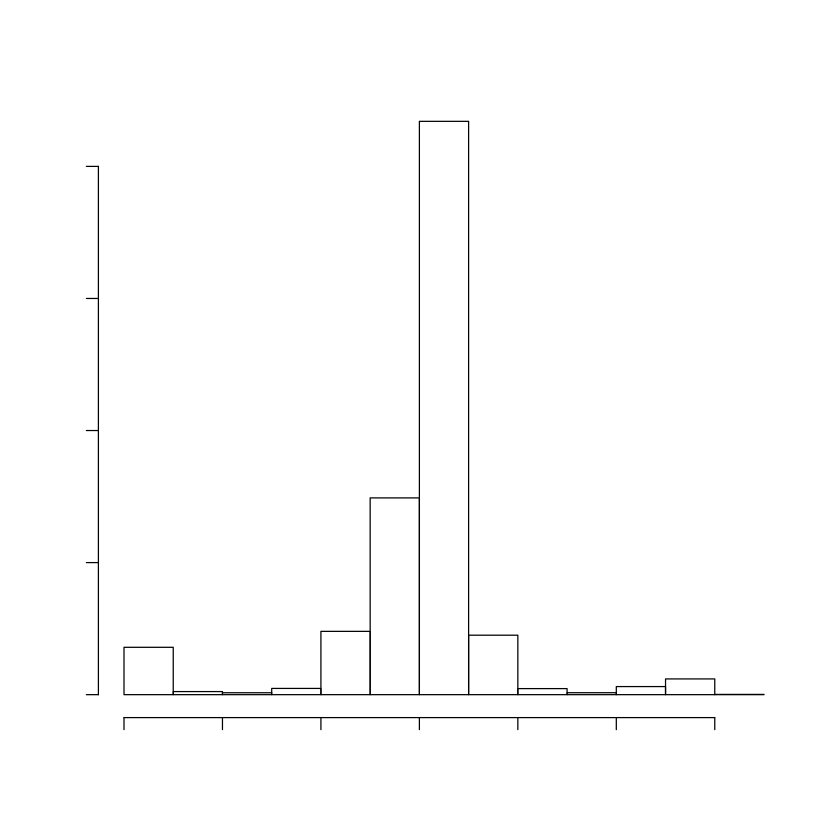

In [365]:
# A "long" sequence is considered a sequence with over 800 bp
bold_seq_long <- bold_seq_lengths[n_nucs > 800]

bold_seq_long[, end_count := str_length(str_extract(nucleotides, "[^[A-Za-z]]*$"))][, end_prop := end_count / n_nucs]

paste0("Proportion of long sequences with end gaps that make up > 30% of the sequence: ", 
       length(bold_seq_long$end_prop[bold_seq_long$end_prop > 0.3]) / nrow(bold_seq_long))

hist(bold_seq_long$end_prop)

In [366]:
bold_seq_trimmed <- bold_seq_lengths[,nucs_trimmed := str_remove(nucleotides, "[^[A-Za-z]]*$")
                                    ][,nucs_trimmed := str_remove(nucs_trimmed, "^[^[A-Za-z]]*")
                                     ][,n_trimmed := str_length(nucs_trimmed)
                                     ][,length_prop := n_trimmed / n_nucs
                                      ]


summary(bold_seq_trimmed$length_prop)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.1109  0.9145  0.9871  0.9481  1.0000  1.0000 

Trimming the ends greatly reduced the number of long sequences in the data set.

In [367]:
paste0("Number of long sequences in full data set: ", nrow(bold_seq_lengths[n_nucs > 800]))
paste0("Number of long sequences in trimmed data set: ", nrow(bold_seq_trimmed[n_trimmed > 800]))
paste0("Proportion: ", nrow(bold_seq_trimmed[n_trimmed > 800]) / nrow(bold_seq_lengths[n_nucs > 800]))

[1] "Number of long sequences in full data set: 74478"

[1] "Number of long sequences in trimmed data set: 3951"

[1] "Proportion: 0.053049222589221"

Short sequences make up a small proportion of total sequences. Removing these probably won't impact the overall number of cells we recover. If included, they could impact the diversity measurements made from those alignments, so I'm going to remove them and see what happens. Using 400 as a threshold because BOLD's lower threshold for BIN assignment is 300, but we're interested in nucleotide diversity, so a more conservative threshold is warranted

In [368]:
nrow(bold_seq_trimmed[n_trimmed < 400])
nrow(bold_seq_trimmed[n_trimmed < 400]) / nrow(bold_seq_trimmed)

[1] 5954

[1] 0.001803682

I'm taking a closer look at the distribution of gaps in sequences with the end gaps trimmed off. It looks like there are still some sequences with a large number of gaps, even with the ends trimmed!



In [369]:
# how many gaps are in the trimmed sequences?
bold_seq_trimmed <- bold_seq_trimmed[, n_gaps_trim := str_count(nucs_trimmed, "-")]

sum(bold_seq_trimmed$n_gaps_trim > 100)


[1] 481

Let's see the number of nucleotides after removing ALL gaps. It reduces the number of long sequences, but does not account for all of them. 

In [370]:
bold_seq_trimmed <- bold_seq_trimmed[, nucs_all_trim := str_remove_all(nucs_trimmed, "-")
                                    ][, n_nucs_all_trim := str_length(nucs_all_trim)]



paste0("Before: ", nrow(bold_seq_trimmed[n_trimmed > 800]))
paste0("After: ", nrow(bold_seq_trimmed[n_nucs_all_trim > 800]))

[1] "Before: 3951"

[1] "After: 3790"

In [371]:
paste0("Mean before: ", mean(bold_seq_trimmed$n_trimmed))

paste0("Mean after: ", mean(bold_seq_trimmed$n_nucs_all_trim))

paste0("Median before: ", median(bold_seq_trimmed$n_nucs_all_trim))

paste0("Median after: ", median(bold_seq_trimmed$n_nucs_all_trim))

[1] "Mean before: 616.017805681569"

[1] "Mean after: 614.463911663801"

[1] "Median before: 624"

[1] "Median after: 624"

A high number of ambiguous bases may be adding to sequence length, and a high proportion of ambiguous bases indicates poor sequencing anyways. A 1% threshold is typical. I'm also filtering for the exceptionally long sequences at this point. Including long sequences can mess up the alignments and may include primers or Wolbachia/bacterial insertions that we're not interested in. I'm filtering out any sequence longer than 800 basepairs. In addition, I'm filtering out short sequences (<400 bp), as these are fragments and are allowed in the BOLD database for matching to existing OTUs, but not for assessing diversity.  

*Note- I wanted to check for primers in sequences, but the BOLD primer database doesn't have FASTAs for a lot of the primers. For many, the "FASTA file" is really just a reference number for the sequence in its publication. Since it would be a herculean effort for just a small fraction of the sequences, I'm going to remove all of the long sequences.*

In [372]:
bold_seq_trimmed  <- bold_seq_trimmed[, prop_ambig := str_count(nucs_all_trim, "N") / n_nucs_all_trim]

In [373]:
# filter for ambiguous bases and long sequences
bold_seq_filtered <- bold_seq_trimmed[prop_ambig <= .01][n_nucs_all_trim <= 800 & n_nucs_all_trim >= 400]

paste0("Number of sequences before filtering: ", nrow(bold_seq_trimmed))
paste0("Number of sequences after filtering: ", nrow(bold_seq_filtered))
paste0("Difference: ", nrow(bold_seq_trimmed) - nrow(bold_seq_filtered))


[1] "Number of sequences before filtering: 3301025"

[1] "Number of sequences after filtering: 3243308"

[1] "Difference: 57717"

## Filter geography and invasive species

Filter the data set for five or more sequences per OTU per cell and ten or more OTUs per cell. Note that the **numseqs** column indicates the number of sequences per cell for the entire OTU, not the individual. Therefore, there will be repetition of this number across individuals within an OTU per cell. There's definitely a more concise way to do this, but I wanted to retain the number of sequences and number of OTUs as columns, so I'm doing it the long way.

In [374]:
# add in the relevant columns from the bold_seq_filtered data set and remove any non-matches
pts_ext_seqfilter <- pts_ext[bold_seq_filtered[,.(recordID, n_nucs_all_trim)], on = "recordID", nomatch = 0]

# get the number of sequences per OTU per cell
pts_ext_numseqs <- pts_ext_seqfilter[, cells := as.factor(cells)][,keyby = .(bin_uri, cells), .(numseqs = .N)]

# combine with the original data set. 
pts_ext_full <- pts_ext_seqfilter[pts_ext_numseqs, on = .(bin_uri, cells)]

# filter for greater than or equal to 5 sequences per bin_uri per cell
pts_ext_filtered <- pts_ext_full[numseqs >= 5]

# get the number of OTUs per cell
pts_ext_otus <- pts_ext_filtered[,keyby = "cells", .(numotus = uniqueN(bin_uri))]

# combine with filtered data set
pts_ext_filtered <- pts_ext_filtered[pts_ext_otus, on = "cells", nomatch = 0]

# filter for 10 or more OTUs per cell
pts_ext_filtered <- pts_ext_filtered[numotus >= 10]


pts_ext_filtered

recordID,bin_uri,order_taxID,order_name,family_taxID,family_name,subfamily_taxID,subfamily_name,genus_taxID,genus_name,⋯,seq_primers,marker_codes,full_name,cells,chelsa_300km.1,longitude,latitude,n_nucs_all_trim,numseqs,numotus
<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,⋯,<chr>,<chr>,<chr>,<fct>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>
5086047,BOLD:AAA3750,127,Diptera,1730,Culicidae,2142,Culicinae,6438,Aedes,⋯,C_LepFolR,COI-5P,NA,20,-151.8424,-11535031,7027265,534,12,53
5085883,BOLD:AAA3750,127,Diptera,1730,Culicidae,2142,Culicinae,6438,Aedes,⋯,C_LepFolR,COI-5P,NA,20,-151.8424,-11535031,7027265,588,12,53
5085882,BOLD:AAA3750,127,Diptera,1730,Culicidae,2142,Culicinae,6438,Aedes,⋯,C_LepFolR,COI-5P,NA,20,-151.8424,-11535031,7027265,588,12,53
5086188,BOLD:AAA3750,127,Diptera,1730,Culicidae,2142,Culicinae,6438,Aedes,⋯,C_LepFolR,COI-5P,NA,20,-151.8424,-11535031,7027265,633,12,53
5086575,BOLD:AAA3750,127,Diptera,1730,Culicidae,2142,Culicinae,6438,Aedes,⋯,C_LepFolR,COI-5P,NA,20,-151.8424,-11535031,7027265,588,12,53
5086076,BOLD:AAA3750,127,Diptera,1730,Culicidae,2142,Culicinae,6438,Aedes,⋯,C_LepFolR,COI-5P,NA,20,-151.8424,-11535031,7027265,602,12,53
5085950,BOLD:AAA3750,127,Diptera,1730,Culicidae,2142,Culicinae,6438,Aedes,⋯,C_LepFolR,COI-5P,NA,20,-151.8424,-11535031,7027265,564,12,53
5086034,BOLD:AAA3750,127,Diptera,1730,Culicidae,2142,Culicinae,6438,Aedes,⋯,C_LepFolR,COI-5P,NA,20,-151.8424,-11535031,7027265,552,12,53
5085924,BOLD:AAA3750,127,Diptera,1730,Culicidae,2142,Culicinae,6438,Aedes,⋯,C_LepFolR,COI-5P,NA,20,-151.8424,-11535031,7027265,633,12,53


In [375]:
paste0("Number of cells retained: ", uniqueN(pts_ext_filtered$cells))

[1] "Number of cells retained: 481"

This is an updated species list with the filtered individuals. We're matching this against invasive species databases to see if we need to worry about having too many of them in our data set. The idea is that species invasive to an area will have lower genetic diversity than native species because of a founder effect. This can bias our calculations away from getting the "natural" variation in genetic diversity.

In [376]:
bold_meta_filtered_unique <- unique(pts_ext_filtered, by = c("full_name"))

# select taxon columns, remove any "sp." Some species names omit the "sp." and just give someone's name (always capitalized) 
# or numeric identifier
bold_meta_filtered_taxa  <- bold_meta_filtered_unique[, .(order_name, family_name, subfamily_name, genus_name, species_name)][
    !str_detect(species_name, "sp.")][,
    sp_suffix := str_split_fixed(species_name, " ", n = 2)[,2]][
    !str_detect(sp_suffix, "[[:upper:]]") &
    !str_detect(sp_suffix, "[0-9]")] 

paste("Number of unique named species:", nrow(bold_meta_filtered_taxa))
head(bold_meta_taxa)

fwrite(bold_meta_filtered_taxa, here("output", "spreadsheets", paste0("bold_taxa_list_filtered_", res, ".csv")))

[1] "Number of unique named species: 23890"

order_name,family_name,subfamily_name,genus_name,species_name,sp_suffix
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
Lepidoptera,Geometridae,Ennominae,Paralaea,Paralaea porphyrinaria,porphyrinaria
Hemiptera,Nepidae,Ranatrinae,Ranatra,Ranatra linearis,linearis
Lepidoptera,Noctuidae,Condicinae,Condica,Condica abida,abida
Diptera,Sphaeroceridae,Limosininae,Spelobia,Spelobia semioculata,semioculata
Diptera,Mycetophilidae,Mycetophilinae,Mycetophila,Mycetophila perpallida,perpallida
Diptera,Ceratopogonidae,Forcipomyiinae,Forcipomyia,Forcipomyia titillans,titillans


There are many cells with especially few or especially many nucleotides (<<500 or >>650). I'm seeing if these may impact alignments by calculating the standard deviation and range in sequence length per OTU per cell. Although there are some OTUs with a relatively wide range in sequence lengths, there are none where sequence overlap is less than 50% (using Miraldo et al.'s guideline). So, it seems like I'm good to go with the sequences obtained so far.

In [377]:
pts_var <- pts_ext_filtered[,keyby= .(bin_uri, cells), .(nuc_sd = sd(n_nucs_all_trim), 
                                                         nuc_range = max(n_nucs_all_trim) - min(n_nucs_all_trim),
                                                         nuc_min = min(n_nucs_all_trim),
                                                         nuc_max = max(n_nucs_all_trim))
                           ][,prop_overlap := nuc_min / nuc_max]

summary(pts_var$nuc_sd)
summary(pts_var$nuc_range)
summary(pts_var$prop_overlap)
paste0("The number of OTUs before filtering for sequence overlap > 0.50: ", nrow(pts_var))
paste0("The number of OTUs after filtering for sequence overlap > 0.50: ", nrow(pts_var[prop_overlap >= 0.5]))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   5.093  19.010  21.660  33.673 140.217 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00   15.00   60.00   66.45  105.00  278.00 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.5968  0.8389  0.9036  0.8969  0.9757  1.0000 

[1] "The number of OTUs before filtering for sequence overlap > 0.50: 108795"

[1] "The number of OTUs after filtering for sequence overlap > 0.50: 108795"

See which OTUs are present in multiple continents. 

In [378]:
world_map <- rnaturalearth::ne_countries(returnclass = "sf") %>% 
    st_transform(crs = behrmann_crs)

pts_ext_sf <- st_as_sf(pts_ext_filtered, crs = behrmann_crs, coords = c("longitude", "latitude"))

# Find country of each coordinate:
map_inter <- sf::st_intersects(pts_ext_sf, world_map)

# have to replace zero-length st_intersects values with NA before subsetting. unlist() removes the empty cells
pts_ext_sf$continents <- world_map$continent[map_dbl(map_inter, function(x) if(length(x) < 1) NA else x)]




In [379]:
fwrite(pts_ext_sf, here("output", "spreadsheets", paste0("filtered_with_continents_", res, ".csv")))

Get the number of continents each OTU belongs to, filter for OTUs that belong to more than one continent, and remove unknown species ("sp.", "cf.", "nr.", "s.l.", "pr." "group", "complex") and arbitrary labels not mapping to species (determined by the species name beginning with a capital letter). In addition, there are some records with the prefix "jft" that escape my other filters that I have to filter out. There are still duplicates, where the species name is followed by some identifier, but I would rather keep these duplicates than risk removing real species names. Of note: you may notice that some of the species say that there are records in more than one continent, but there is only one continent listed for the species. This is because the counts are based on OTU. The OTU associated with the species is in multiple continents, but for some reason, people submitting the other specimens didn't list a species name with the OTU (probably because they couldn't identify the specimen to species level via other methods).

In [380]:
# convert back to data.table
setDT(pts_ext_sf)

continent_counts <- pts_ext_sf[, num_continents := uniqueN(continents), keyby = "bin_uri"]

multi_continents <- continent_counts[num_continents > 1]

# A long chain of filters, but I think it's more readable than splitting up. I could collapse the str_detect() calls, but whatever. It's still readable.
multi_continents <- multi_continents[, unique(species_name), 
                                     keyby = .(bin_uri, 
                                               order_name, 
                                               family_name, 
                                               subfamily_name, 
                                               genus_name, 
                                               num_continents)
                                    ][, species_name := V1
                                    ][!is.na(species_name)
                                    ][,V1 := NULL
                                    ][!str_detect(species_name, "sp.|cf.|nr.|complex|group")
                                    # removing edge cases. tedious, but necessary
                                    ][,species_name := str_remove(species_name, "var. | 1| s.str.")
                                    ][,species_name := str_replace(species_name, "quenseli quenseli", "quenseli")
                                    ][,species_name := str_replace(species_name, "melanarius melanarius", "melanurius")
                                    ][,species_name := str_replace(species_name, "fuscipes fuscipes", "fuscipes")
                                    ][,species_name := str_remove(species_name, "Ch$|_A$|-B$|-A$|Pe$")
                                    ][,species_name := str_remove(species_name, "_(.*)")
                                    ][,sp_suffix := str_split_fixed(species_name, " ", 2)[,2]
                                    ][!str_detect(sp_suffix, "^[A-Z]")
                                    ][,species_name := str_remove(species_name, "[A-Z]+[0-9]+") %>% str_trim()
                                    ][,sp_suffix := str_remove(sp_suffix, "[A-Z]+[0-9]+") %>% str_trim()
                                    ][!str_starts(sp_suffix, "jft| s.l.| sl|pr. ")
                                    ][,species_name := str_remove(species_name, "[0-9][0-9]")
                                    ][,sp_suffix := str_remove(sp_suffix, "[0-9][0-9]")
                                    ][!duplicated(species_name)]

paste0("Number of observations: ", nrow(multi_continents))
head(multi_continents)


[1] "Number of observations: 4638"

bin_uri,order_name,family_name,subfamily_name,genus_name,num_continents,species_name,sp_suffix
<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>
BOLD:AAA0257,Lepidoptera,Crambidae,Spilomelinae,Maruca,2,Maruca testulalis,testulalis
BOLD:AAA0257,Lepidoptera,Crambidae,Spilomelinae,Maruca,2,Maruca vitrata,vitrata
BOLD:AAA0317,Lepidoptera,Erebidae,Arctiinae,Phoenicoprocta,2,Phoenicoprocta lydia,lydia
BOLD:AAA0321,Lepidoptera,Crambidae,Pyraustinae,Hyalorista,2,Hyalorista exuvialis,exuvialis
BOLD:AAA0406,Lepidoptera,Crambidae,Spilomelinae,Asturodes,2,Asturodes fimbriauralis,fimbriauralis
BOLD:AAA0408,Lepidoptera,Crambidae,Spilomelinae,Desmia,4,Desmia bajulalis,bajulalis


For 100 km aggregation:
There are 2426 unique OTUs within 3015 unique species that are present on multiple continents. If I don't filter for records with species names, there are 4281 OTUs present on multiple continents. This makes up 0.19% of the total number of OTUs in the dataset.

In [381]:
paste0("There are ", multi_continents %>% summarize(n = uniqueN(bin_uri)) %>% pull(n), " unique OTUs associated with species names present in multiple continents.")

paste0("There are ", multi_continents %>% summarize(n = uniqueN(species_name)) %>% pull(n), " unique species present in multiple continents.")

paste0("There are ", nrow(continent_counts[num_continents > 1][!duplicated(bin_uri)]), " total OTUs present in multiple continents.")

paste0("This is ", round(nrow(continent_counts[num_continents > 1][!duplicated(bin_uri)]) / nrow(continent_counts) * 100, 2), "% of the total number of OTUs in the dataset.")


[1] "There are 3576 unique OTUs associated with species names present in multiple continents."

[1] "There are 4638 unique species present in multiple continents."

[1] "There are 5856 total OTUs present in multiple continents."

[1] "This is 0.25% of the total number of OTUs in the dataset."

Now I'm going to match this specimen list to a few invasive species databases. The first is the Global Invasive Species Database, which is run by the Invasive Species Specialist Group. I searched for all animals under the class Insecta and downloaded the resulting CSV. Downloaded: 4-23-20.

In [382]:
invasive_gisd <- read_csv2(here("data", "invasive", "export_gisd.csv")) %>% 
    select(-X8) %>% 
    rename_all(list(~tolower(.) %>% str_c("_name"))) %>% 
    mutate(source = "http://www.iucngisd.org/gisd/search.php",
           source_id = "gisd") %>% 
    select(species_name, source, source_id)

head(invasive_gisd)

Using ',' as decimal and '.' as grouping mark. Use read_delim() for more control.

Warning message:
“Missing column names filled in: 'X8' [8]”
Parsed with column specification:
cols(
  Species = col_character(),
  Kingdom = col_character(),
  Phylum = col_character(),
  Class = col_character(),
  Order = col_character(),
  Family = col_character(),
  System = col_character(),
  X8 = col_logical()
)



species_name,source,source_id
<chr>,<chr>,<chr>
Acnemia bifida,http://www.iucngisd.org/gisd/search.php,gisd
Acromyrmex octospinosus,http://www.iucngisd.org/gisd/search.php,gisd
Adelges piceae,http://www.iucngisd.org/gisd/search.php,gisd
Adelges tsugae,http://www.iucngisd.org/gisd/search.php,gisd
Aedes aegypti,http://www.iucngisd.org/gisd/search.php,gisd
Aedes albopictus,http://www.iucngisd.org/gisd/search.php,gisd


The next is the [Invasive Species Compendium](https://www.cabi.org/isc/), a database compiled by the Centre for Agriculture and Bioscience International. I used the search term "insecta" and refined the results by the class Insecta. Downloaded: 4-24-20. 

In [383]:
invasive_icf <- read_csv(here("data", "invasive", "isc_cabi.csv")) %>% 
    select(-c(`Common name`, Coverage, X5)) %>% 
    rename(species_name = `Scientific name`, source = URL) %>% 
    mutate(source_id = "icf")

head(invasive_icf)

Warning message:
“Missing column names filled in: 'X5' [5]”
Parsed with column specification:
cols(
  `Scientific name` = col_character(),
  `Common name` = col_character(),
  Coverage = col_character(),
  URL = col_character(),
  X5 = col_logical()
)



species_name,source,source_id
<chr>,<chr>,<chr>
Contarinia jongi,https://www.cabi.org/isc/datasheet/96735061,icf
Vespa mandarinia,https://www.cabi.org/isc/datasheet/35294260,icf
Aleurodicus rugioperculatus,https://www.cabi.org/isc/datasheet/122299,icf
Bactrocera carambolae,https://www.cabi.org/isc/datasheet/8700,icf
Paracoccus marginatus,https://www.cabi.org/isc/datasheet/39201,icf
Bactrocera oleae,https://www.cabi.org/isc/datasheet/17689,icf


The Center for Invasive Species and Ecosystem Health has a list of invasive insect species in North America. They don't have an easy way to download their data, so I'm going to scrape it. After trial and error with some web scraping tools, the way the webpage has the table formatted makes it difficult to scrape. So, I used the [datapasta](https://github.com/MilesMcBain/datapasta) RStudio addin to copy-paste the table as a dataframe. It worked nicely! Scraped: 4-24-2020.

In [384]:
# make a tibble of the table
invasive_na <- tibble::tribble(
                                            ~Subject.Name,                          ~Scientific.Name,           ~Family,         ~Order,
                                       "Chinese rose beetle",                        "Adoretus sinicus",    "Scarabaeidae",   "Coleoptera",
                                 "coconut rhinoceros beetle",                      "Oryctes rhinoceros",    "Scarabaeidae",   "Coleoptera",
                                              "ash whitefly",                   "Siphoninus phillyreae",     "Aleyrodidae",    "Hemiptera",
                                    "yellow-horned horntail",              "Urocerus gigas flavicornis",       "Siricidae",  "Hymenoptera",
                                      "southern pine beetle",                  "Dendroctonus frontalis",   "Curculionidae",   "Coleoptera",
                                      "mountain pine beetle",                 "Dendroctonus ponderosae",   "Curculionidae",   "Coleoptera",
                                             "spruce beetle",                 "Dendroctonus rufipennis",   "Curculionidae",   "Coleoptera",
                          "smaller European elm bark beetle",                  "Scolytus multistriatus",   "Curculionidae",   "Coleoptera",
                                        "pine false webworm",              "Acantholyda erythrocephala",    "Pamphiliidae",  "Hymenoptera",
                                    "introduced pine sawfly",                         "Diprion similis",     "Diprionidae",  "Hymenoptera",
                                            "browntail moth",                  "Euproctis chrysorrhoea",    "Lymantriidae",  "Lepidoptera",
                                          "white satin moth",                         "Leucoma salicis",    "Lymantriidae",  "Lepidoptera",
                                         "aspen blotchminer",                "Phyllonorycter apparella",  "Gracillariidae",  "Lepidoptera",
                                                "gypsy moth",                        "Lymantria dispar",    "Lymantriidae",  "Lepidoptera",
                                   "forest tent caterpillar",                     "Malacosoma disstria",   "Lasiocampidae",  "Lepidoptera",
                                          "citrus leafminer",                  "Phyllocnistis citrella",  "Gracillariidae",  "Lepidoptera",
                                           "Japanese beetle",                       "Popillia japonica",    "Scarabaeidae",   "Coleoptera",
                                           "elm leaf beetle",                  "Xanthogaleruca luteola",   "Chrysomelidae",   "Coleoptera",
                                      "whitefringed beetles",                          "Naupactus spp.",   "Curculionidae",   "Coleoptera",
                                         "black vine weevil",                   "Otiorhynchus sulcatus",   "Curculionidae",   "Coleoptera",
                                     "balsam woolly adelgid",                          "Adelges piceae",       "Adelgidae",    "Hemiptera",
                                    "hemlock woolly adelgid",                          "Adelges tsugae",       "Adelgidae",    "Hemiptera",
                                               "beech scale",                   "Cryptococcus fagisuga",    "Eriococcidae",    "Hemiptera",
                                    "elongate hemlock scale",                        "Fiorinia externa",     "Diaspididae",    "Hemiptera",
                                         "coconut red scale",                      "Furcaspis oceanica",     "Diaspididae",    "Hemiptera",
                                     "Egyptian fluted scale",                       "Icerya aegyptiaca",   "Monophlebidae",    "Hemiptera",
                                         "oystershell scale",                       "Lepidosaphes ulmi",     "Diaspididae",    "Hemiptera",
                                         "pine bark adelgid",                           "Pineus strobi",       "Adelgidae",    "Hemiptera",
                                               "pear thrips",               "Taeniothrips inconsequens",       "Thripidae", "Thysanoptera",
                                   "poplar-and-willow borer",                  "Cryptorhynchus lapathi",   "Curculionidae",   "Coleoptera",
                                             "pinhole borer",                           "Platypus spp.",   "Curculionidae",   "Coleoptera",
                               "New Guinea sugarcane weevil",                   "Rhabdoscelus obscurus",   "Curculionidae",   "Coleoptera",
                                  "European pine shoot moth",                     "Rhyacionia buoliana",     "Tortricidae",  "Lepidoptera",
                                          "black twig borer",                   "Xylosandrus compactus",   "Curculionidae",   "Coleoptera",
                                        "citrus flower moth",                             "Prays citri",   "Yponomeutidae",  "Lepidoptera",
                                  "goldenhaired bark beetle",                     "Hylurgus ligniperda",   "Curculionidae",   "Coleoptera",
                                "six-spined engraver beetle",                         "Ips sexdentatus",   "Curculionidae",   "Coleoptera",
                               "European spruce bark beetle",                         "Ips typographus",   "Curculionidae",   "Coleoptera",
                                                "seed worms",                              "Cydia spp.",     "Tortricidae",  "Lepidoptera",
                                  "larger pine shoot beetle",                       "Tomicus piniperda",   "Curculionidae",   "Coleoptera",
                                       "spruce zebra beetle",                   "Xylotrechus undulatus",    "Cerambycidae",   "Coleoptera",
                            "multicolored Asian lady beetle",                       "Harmonia axyridis",   "Coccinellidae",   "Coleoptera",
                                           "European mantid",                        "Mantis religiosa",        "Mantidae",     "Mantodea",
                                        "Asiatic oak weevil",                 "Cyrtepistomus castaneus",   "Curculionidae",   "Coleoptera",
                                   "Asian longhorned beetle",                "Anoplophora glabripennis",    "Cerambycidae",   "Coleoptera",
                                          "May-June beetles",                        "Phyllophaga spp.",    "Scarabaeidae",   "Coleoptera",
                            "Japanese cedar longhorn beetle",                  "Callidiellum rufipenne",    "Cerambycidae",   "Coleoptera",
                                       "European corn borer",                      "Ostrinia nubilalis",       "Crambidae",  "Lepidoptera",
                                 "granulate ambrosia beetle",               "Xylosandrus crassiusculus",   "Curculionidae",   "Coleoptera",
                                               "boll weevil",              "Anthonomus grandis grandis",   "Curculionidae",   "Coleoptera",
                                             "plum curculio",                  "Conotrachelus nenuphar",   "Curculionidae",   "Coleoptera",
                                        "tawny mole cricket",                    "Scapteriscus vicinus",  "Gryllotalpidae",   "Orthoptera",
                                              "Corn earworm",                         "Helicoverpa zea",       "Noctuidae",  "Lepidoptera",
                                    "Colorado potato beetle",               "Leptinotarsa decemlineata",   "Chrysomelidae",   "Coleoptera",
                                             "beet armyworm",                       "Spodoptera exigua",       "Noctuidae",  "Lepidoptera",
                                     "western flower thrips",              "Frankliniella occidentalis",       "Thripidae", "Thysanoptera",
                                    "yellowstriped armyworm",                 "Spodoptera ornithogalli",       "Noctuidae",  "Lepidoptera",
                                           "dusky clearwing",                "Paranthrene tabaniformis",        "Sesiidae",  "Lepidoptera",
                                   "spotted cucumber beetle",      "Diabrotica undecimpunctata howardi",   "Chrysomelidae",   "Coleoptera",
                                             "cabbage white",                            "Pieris rapae",        "Pieridae",  "Lepidoptera",
                                       "Mexican bean beetle",                    "Epilachna varivestis",   "Coccinellidae",   "Coleoptera",
                                      "sweetpotato whitefly",                          "Bemisia tabaci",     "Aleyrodidae",    "Hemiptera",
                                                   "weevils",                      "Conotrachelus spp.",   "Curculionidae",   "Coleoptera",
                                            "alfalfa weevil",                          "Hypera postica",   "Curculionidae",   "Coleoptera",
                                           "European hornet",                            "Vespa crabro",        "Vespidae",  "Hymenoptera",
                                             "cypress aphid",                         "Cinara cupressi",       "Aphididae",    "Hemiptera",
                                              "Quetta Borer",                        "Trirachys sartus",    "Cerambycidae",   "Coleoptera",
                                  "citrus longhorned beetle",                   "Anoplophora chinensis",    "Cerambycidae",   "Coleoptera",
                                             "pine flat bug",                      "Aradus cinnamomeus",        "Aradidae",    "Hemiptera",
                                                "white grub",                  "Brachysternus prasinus",    "Scarabaeidae",   "Coleoptera",
                                     "flat headed woodborer",                 "Buprestis novemmaculata",     "Buprestidae",   "Coleoptera",
                                        "long-horned beetle",                          "Eryphus laetus",    "Cerambycidae",   "Coleoptera",
                               "brown fir longhorned beetle",                 "Callidiellum villosulum",    "Cerambycidae",   "Coleoptera",
                                    "branch borer of coigue",                   "Callisphyris leptopus",    "Cerambycidae",   "Coleoptera",
               "bark boring beetle of dead and dying coigue",                   "Calydon submetallicum",    "Cerambycidae",   "Coleoptera",
                                      "wood borer of coigue",                    "Cheloderus childreni",    "Cerambycidae",   "Coleoptera",
                                            "carpenter worm",                 "Chilecomadia valdiviana",        "Cossidae",  "Lepidoptera",
                                        "long-horned beetle",                "Neocolobura alboplagiata",    "Cerambycidae",   "Coleoptera",
                    "west indian powderpost drywood termite",                     "Cryptotermes brevis",  "Kalotermitidae",     "Isoptera",
                                           "drywood termite",                       "Cryptotermes spp.",  "Kalotermitidae",     "Isoptera",
                                  "great spruce bark beetle",                     "Dendroctonus micans",   "Curculionidae",   "Coleoptera",
                                         "pine bark anobiid",                         "Ernobius mollis",       "Anobiidae",   "Coleoptera",
                                    "flower longhorn beetle",                 "Proholopterus chilensis",    "Cerambycidae",   "Coleoptera",
                                          "wheat white grub",                      "Hylamorpha elegans",    "Scarabaeidae",   "Coleoptera",
                                    "black pine bark beetle",                           "Hylastes ater",   "Curculionidae",   "Coleoptera",
                                                  "nun moth",                       "Lymantria monacha",    "Lymantriidae",  "Lepidoptera",
                                      "Japanese pine sawyer",                   "Monochamus saltuarius",    "Cerambycidae",   "Coleoptera",
                                          "dampwood termite",                     "Neotermes chilensis",  "Kalotermitidae",     "Isoptera",
                                   "cambium miner of coigue",                     "Notiopostega atrata",     "Opostegidae",  "Lepidoptera",
                                         "spiny caterpillar",                   "Ormiscodes cinnamomea",     "Saturniidae",  "Lepidoptera",
                        "Mediterranean pine engraver beetle",                     "Orthotomicus erosus",   "Curculionidae",   "Coleoptera",
                                         "damp wood termite",                     "Porotermes adamsoni",     "Termopsidae",     "Isoptera",
                                         "damp wood termite",                 "Porotermes quadricollis",     "Termopsidae",     "Isoptera",
                                                   "katydid",                    "Pterophylla beltrani",   "Tettigoniidae",   "Orthoptera",
                                               "bark weevil",                         "Rhyephenes gayi",   "Curculionidae",   "Coleoptera",
                                "Chilean pine spider weevil",                    "Rhyephenes humeralis",   "Curculionidae",   "Coleoptera",
                                       "spotted tree weevil",                    "Rhyephenes lateralis",   "Curculionidae",   "Coleoptera",
                                         "black tree weevil",                      "Rhyephenes maillei",   "Curculionidae",   "Coleoptera",
                                               "purple moth",                      "Sarsina violascens",    "Lymantriidae",  "Lepidoptera",
                                  "European oak bark beetle",                     "Scolytus intricatus",   "Curculionidae",   "Coleoptera",
                                                "white grub",                     "Sericoides germaini",    "Scarabaeidae",   "Coleoptera",
                                        "long-horned beetle",                        "Zehra coemeterii",    "Cerambycidae",   "Coleoptera",
                                                "vine borer",                     "Sinoxylon perforans",    "Bostrichidae",   "Coleoptera",
                                            "Sirex woodwasp",                          "Sirex noctilio",       "Siricidae",  "Hymenoptera",
                                       "bagworm, basket bug",                 "Thanatopsyche chilensis",       "Psychidae",  "Lepidoptera",
                               "Altai larch longhorn beetle",                    "Xylotrechus altaicus",    "Cerambycidae",   "Coleoptera",
                                      "oak splendour beetle",                      "Agrilus biguttatus",     "Buprestidae",   "Coleoptera",
                 "small white-marmorated long-horned beetle",                        "Monochamus sutor",    "Cerambycidae",   "Coleoptera",
                                              "poplar borer",                      "Saperda carcharias",    "Cerambycidae",   "Coleoptera",
                                        "small poplar borer",                        "Saperda populnea",    "Cerambycidae",   "Coleoptera",
                                       "black spruce beetle",                     "Tetropium castaneum",    "Cerambycidae",   "Coleoptera",
                              "brown spruce longhorn beetle",                        "Tetropium fuscum",    "Cerambycidae",   "Coleoptera",
                                  "large brown trunk beetle",                        "Hylobius abietis",   "Curculionidae",   "Coleoptera",
                                  "small banded pine weevil",                      "Pissodes castaneus",   "Curculionidae",   "Coleoptera",
                                           "engraver beetle",                          "Ips acuminatus",   "Curculionidae",   "Coleoptera",
                                     "larch engraver beetle",                        "Ips subelongatus",   "Curculionidae",   "Coleoptera",
                            "six-toothed spruce bark beetle",                "Pityogenes chalcographus",   "Curculionidae",   "Coleoptera",
                                          "large elm beetle",                       "Scolytus scolytus",   "Curculionidae",   "Coleoptera",
                                  "lesser pine shoot beetle",                           "Tomicus minor",   "Curculionidae",   "Coleoptera",
                         "European hardwood ambrosia beetle",                 "Trypodendron domesticum",   "Curculionidae",   "Coleoptera",
                                          "black stem borer",                    "Xylosandrus germanus",   "Curculionidae",   "Coleoptera",
                                         "Siricid woodwasps",                          "Sirex juvencus",       "Siricidae",  "Hymenoptera",
                                          "ambrosia beetles",                          "Xyleborus spp.",   "Curculionidae",   "Coleoptera",
                             "formosan subterranean termite",                  "Coptotermes formosanus", "Rhinotermitidae",     "Isoptera",
                                   "pine processionary moth",                 "Thaumetopoea pityocampa",    "Notodontidae",  "Lepidoptera",
                                      "Japanese pine sawyer",                   "Monochamus alternatus",    "Cerambycidae",   "Coleoptera",
                                   "Masson pine caterpillar",                   "Dendrolimus punctatus",   "Lasiocampidae",  "Lepidoptera",
                                           "rosy gypsy moth",                       "Lymantria mathura",    "Lymantriidae",  "Lepidoptera",
                           "Mediterranean fruit fly, Medfly",                      "Ceratitis capitata",     "Tephritidae",      "Diptera",
                                     "red imported fire ant",                      "Solenopsis invicta",      "Formicidae",  "Hymenoptera",
                                   "black imported fire ant",                     "Solenopsis richteri",      "Formicidae",  "Hymenoptera",
                                        "oriental fruit fly",                     "Bactrocera dorsalis",     "Tephritidae",      "Diptera",
                                        "Asiatic rice borer",                      "Chilo suppressalis",       "Crambidae",  "Lepidoptera",
                                               "green scale",                          "Coccus viridis",        "Coccidae",    "Hemiptera",
                                                 "melon fly",                   "Zeugodacus cucurbitae",     "Tephritidae",      "Diptera",
                                         "mango seed weevil",                 "Sternochetus mangiferae",   "Curculionidae",   "Coleoptera",
                           "West Indian sweet potato weevil",                  "Euscepes postfasciatus",   "Curculionidae",   "Coleoptera",
                                    "sweetpotato vine borer",                   "Omphisa anastomosalis",       "Crambidae",  "Lepidoptera",
                                            "scarab beetles",                           "Adoretus spp.",    "Scarabaeidae",   "Coleoptera",
                                             "chafer beetle",                       "Anomala sulcatula",    "Scarabaeidae",   "Coleoptera",
                                                "white grub",                  "Holotrichia mindanaona",    "Scarabaeidae",   "Coleoptera",
                                                 "paddy bug",                       "Leptocorisa acuta",        "Alydidae",    "Hemiptera",
                               "sugarcane spotted aleyrodid",                     "Neomaskellia bergii",     "Aleyrodidae",    "Hemiptera",
                                          "legume pod borer",                          "Maruca vitrata",       "Crambidae",  "Lepidoptera",
                                     "orange spiny whitefly",                "Aleurocanthus spiniferus",     "Aleyrodidae",    "Hemiptera",
                                          "spotted bollworm",                          "Earias vittela",       "Noctuidae",  "Lepidoptera",
                                            "Bean butterfly",                       "Lampides boeticus",      "Lycaenidae",  "Lepidoptera",
                                     "pink-spotted bollworm",                  "Pectinophora scutigera",     "Gelechiidae",  "Lepidoptera",
                                   "citrus pock caterpillar",                         "Prays endocarpa",   "Yponomeutidae",  "Lepidoptera",
                                               "banana moth",                        "Opogona sacchari",        "Tineidae",  "Lepidoptera",
                                         "bromeliad weevils",                         "Metamasius spp.",   "Curculionidae",   "Coleoptera",
                                          "cassava mealybug",                    "Phenococcus manihoti",  "Pseudococcidae",    "Hemiptera",
                                       "avocado seed weevil",                          "Heilipus lauri",   "Curculionidae",   "Coleoptera",
                                           "cocoa pod borer",                 "Conopomorpha cramerella",  "Gracillariidae",  "Lepidoptera",
                                  "Asian chestnut gall wasp",                   "Dryocosmus kuriphilus",       "Cynipidae",  "Hymenoptera",
                                      "onion carpenter worm",                          "Dyspessa ulula",        "Cossidae",  "Lepidoptera",
                                       "chestnut leafroller",                        "Pammene fasciana",     "Tortricidae",  "Lepidoptera",
                                  "European chestnut weevil",                        "Curculio elephas",   "Curculionidae",   "Coleoptera",
                                                "nut weevil",                          "Curculio nucum",   "Curculionidae",   "Coleoptera",
                                          "nut fruit tortix",                         "Cydia splendana",     "Tortricidae",  "Lepidoptera",
                                          "sapote fruit fly",                   "Anastrepha serpentina",     "Tephritidae",      "Diptera",
                                         "Mexican fruit fly",                       "Anastrepha ludens",     "Tephritidae",      "Diptera",
                                               "leaf beetle",                      "Exosoma lusitanica",   "Chrysomelidae",   "Coleoptera",
                                             "pink bollworm",                "Pectinophora gossypiella",     "Gelechiidae",  "Lepidoptera",
                                           "plum fruit moth",                    "Grapholita funebrana",     "Tortricidae",  "Lepidoptera",
                                    "pear leaf blister moth",                 "Leucoptera malifoliella",     "Lyonetiidae",  "Lepidoptera",
                                 "summer fruit tortrix moth",                        "Adoxophyes orana",     "Tortricidae",  "Lepidoptera",
                                   "polyphagous leaf roller",                  "Argyrotaenia ljungiana",     "Tortricidae",  "Lepidoptera",
                                                    "thrips",                   "Haplothrips chinensis", "Phlaeothripidae", "Thysanoptera",
                               "South American cucurbit fly",                      "Anastrepha grandis",     "Tephritidae",      "Diptera",
                                          "peach fruit moth",                    "Carposina niponensis",    "Carposinidae",  "Lepidoptera",
                                         "Yellow peach moth",               "Dichocrocis punctiferalis",       "Crambidae",  "Lepidoptera",
                                             "khapra beetle",                    "Trogoderma granarium",     "Dermestidae",   "Coleoptera",
                                          "papaya fruit fly",                  "Toxotrypana curvicauda",     "Tephritidae",      "Diptera",
                                              "Lucerne flea",                      "Sminthurus viridis",    "Sminthuridae",   "Collembola",
                                    "light brown apple moth",                    "Epiphyas postvittana",     "Tortricidae",  "Lepidoptera",
                                              "click beetle",                    "Conoderes rufangulus",      "Elateridae",   "Coleoptera",
                             "brown Chilean leaf-footed bug",                  "Leptoglossus chilensis",        "Coreidae",    "Hemiptera",
                                  "Chilean vegetable weevil",                  "Listroderes subcinctus",   "Curculionidae",   "Coleoptera",
                                      "tuberous pine weevil",                  "Geniocremnus chilensis",   "Curculionidae",   "Coleoptera",
                                         "fruit tree weevil",                 "Naupactus xanthographus",   "Curculionidae",   "Coleoptera",
                                           "Tortricid moths",                           "Proeulia spp.",     "Tortricidae",  "Lepidoptera",
                                      "Fijian ginger weevil",               "Elytroteinus subtruncatus",   "Curculionidae",   "Coleoptera",
                                                "leafroller",                           "Capua tortrix",     "Tortricidae",  "Lepidoptera",
                                      "Queensland fruit fly",                       "Bactrocera tryoni",     "Tephritidae",      "Diptera",
                                                 "leek moth",                "Acrolepiopsis assectella",    "Acrolepiidae",  "Lepidoptera",
                                              "lily weevils",                        "Brachycerus spp.",   "Brachyceridae",   "Coleoptera",
                                     "west indian fruit fly",                      "Anastrepha obliqua",     "Tephritidae",      "Diptera",
                                  "South American fruit fly",                  "Anastrepha fraterculus",     "Tephritidae",      "Diptera",
                                          "grape berry moth",                         "Lobesia botrana",     "Tortricidae",  "Lepidoptera",
                                               "fruit flies",                         "Pterandrus spp.",     "Tephritidae",      "Diptera",
                                     "old world fruit flies",                          "Ceratitis spp.",     "Tephritidae",      "Diptera",
                                        "false codling moth",                "Thaumatotibia leucotreta",     "Tortricidae",  "Lepidoptera",
                                 "small avocado seed weevil",                 "Conotrachelus aguacatae",   "Curculionidae",   "Coleoptera",
                                           "guava fruit fly",                      "Anastrepha striata",     "Tephritidae",      "Diptera",
                                       "avocado stem weevil",                      "Copturus aguacatae",   "Curculionidae",   "Coleoptera",
                                         "avocado seed moth",                       "Stenoma catenifer",    "Elachistidae",  "Lepidoptera",
                                              "cuckoo wasps",                            "Chrysis spp.",     "Chrysididae",  "Hymenoptera",
                                              "cuckcoo bees",                          "Coelioxys spp.",    "Megachilidae",  "Hymenoptera",
                                     "Africanized honey bee",          "Apis mellifera spp. scutellata",          "Apidae",  "Hymenoptera",
                                            "Cape honey bee",            "Apis mellifera spp. capensis",          "Apidae",  "Hymenoptera",
                                        "coffee berry borer",                     "Hypothenemus hampei",   "Curculionidae",   "Coleoptera",
                                       "Egyptian cottonworm",                   "Spodoptera littoralis",       "Noctuidae",  "Lepidoptera",
                                                 "sunn pest",                  "Eurygaster integriceps",   "Scutelleridae",    "Hemiptera",
                                              "cabbage moth",                      "Mamestra brassicae",       "Noctuidae",  "Lepidoptera",
                                         "potato tuber moth",                 "Phthorimaea operculella",     "Gelechiidae",  "Lepidoptera",
                                          "Pine-tree lappet",                        "Dendrolimus pini",   "Lasiocampidae",  "Lepidoptera",
                                            "conifer sawfly",                            "Diprion pini",     "Diprionidae",  "Hymenoptera",
                                         "emerald ash borer",                     "Agrilus planipennis",     "Buprestidae",   "Coleoptera",
                                           "Asian cockroach",                      "Blattella asahinai",    "Blattellidae",    "Blattodea",
                                          "German cockroach",                     "Blattella germanica",    "Blattellidae",    "Blattodea",
                                        "oriental cockroach",                       "Blatta orientalis",       "Blattidae",    "Blattodea",
                                              "bamboo borer",                  "Chlorophorus annularis",    "Cerambycidae",   "Coleoptera",
                                              "rustic borer",                     "Xylotrechus colonus",    "Cerambycidae",   "Coleoptera",
                                          "lily leaf beetle",                        "Lilioceris lilii",   "Chrysomelidae",   "Coleoptera",
                                        "cereal leaf beetle",                        "Oulema melanopus",   "Chrysomelidae",   "Coleoptera",
                                        "lined click beetle",                       "Agriotes lineatus",      "Elateridae",   "Coleoptera",
                                            "wheat wireworm",                         "Agriotes mancus",      "Elateridae",   "Coleoptera",
                                           "oriental beetle",                      "Anomala orientalis",    "Scarabaeidae",   "Coleoptera",
                                           "European chafer",                      "Amphimallon majale",    "Scarabaeidae",   "Coleoptera",
                                     "larger shothole borer",                           "Scolytus mali",   "Curculionidae",   "Coleoptera",
                                            "shothole borer",                      "Scolytus rugulosus",   "Curculionidae",   "Coleoptera",
                                                  "bean fly",                      "Ophiomyia phaseoli",     "Agromyzidae",      "Diptera",
                                               "wheat midge",                  "Sitodiplosis mosellana",   "Cecidomyiidae",      "Diptera",
                                  "northwest coast mosquito",                        "Aedes aboriginis",       "Culicidae",      "Diptera",
                                      "yellowfever mosquito",                           "Aedes aegypti",       "Culicidae",      "Diptera",
                                      "Asian tiger mosquito",                        "Aedes albopictus",       "Culicidae",      "Diptera",
                                                 "house fly",                         "Musca domestica",        "Muscidae",      "Diptera",
                                                   "torsalo",                      "Dermatobia hominis",       "Oestridae",      "Diptera",
                                           "olive fruit fly",                        "Bactrocera oleae",     "Tephritidae",      "Diptera",
                                          "blueberry maggot",                       "Rhagoletis mendax",     "Tephritidae",      "Diptera",
                                              "apple maggot",                    "Rhagoletis pomonella",     "Tephritidae",      "Diptera",
                                        "European crane fly",                         "Tipula paludosa",       "Tipulidae",      "Diptera",
                                                   "bed bug",                       "Cimex lectularius",       "Cimicidae",    "Hemiptera",
                                        "Caledonia seed bug",                       "Nysius caledoniae",       "Lygaeidae",    "Hemiptera",
                                           "citrus blackfly",                   "Aleurocanthus woglumi",     "Aleyrodidae",    "Hemiptera",
                                     "rhododendron whitefly",              "Massilieurodes chittendeni",     "Aleyrodidae",    "Hemiptera",
                                       "Russian wheat aphid",                         "Diuraphis noxia",       "Aphididae",    "Hemiptera",
                                           "sugarcane aphid",                     "Melanaphis sacchari",       "Aphididae",    "Hemiptera",
                                        "brown citrus aphid",                     "Toxoptera citricida",       "Aphididae",    "Hemiptera",
                                "Virginiacreeper leafhopper",                     "Erythroneura ziczac",    "Cicadellidae",    "Hemiptera",
                                      "gray lawn leafhopper",                     "Exitianus exitiosus",    "Cicadellidae",    "Hemiptera",
                                           "rice leafhopper",                 "Nephotettix nigropictus",    "Cicadellidae",    "Hemiptera",
                                              "calico scale",                    "Eulecanium cerasorum",        "Coccidae",    "Hemiptera",
                                       "sugarcane delphacid",               "Perkinsiella saccharicida",     "Delphacidae",    "Hemiptera",
                                            "oleander scale",                        "Aspidiotus nerii",     "Diaspididae",    "Hemiptera",
                                             "juniper scale",                     "Carulaspis juniperi",     "Diaspididae",    "Hemiptera",
                                         "Florida red scale",                   "Chrysomphalus aonidum",     "Diaspididae",    "Hemiptera",
                                                 "tea scale",                          "Fiorinia theae",     "Diaspididae",    "Hemiptera",
                                              "greedy scale",                      "Hemiberlesia rapax",     "Diaspididae",    "Hemiptera",
                                             "camphor scale",                     "Pseudaonidia duplex",     "Diaspididae",    "Hemiptera",
                                         "white peach scale",               "Pseudaulacaspis pentagona",     "Diaspididae",    "Hemiptera",
                                            "San Jose scale",                "Diaspidiotus perniciosus",     "Diaspididae",    "Hemiptera",
                                            "euonymus scale",                         "Unaspis euonymi",     "Diaspididae",    "Hemiptera",
                                         "azalea bark scale",                      "Eriococcus azaleae",    "Eriococcidae",    "Hemiptera",
                                          "grape phylloxera",               "Daktulosphaira vitifoliae",   "Phylloxeridae",    "Hemiptera",
                                         "Comstock mealybug",                  "Pseudococcus comstocki",  "Pseudococcidae",    "Hemiptera",
                                             "Argentine ant",                      "Linepithema humile",      "Formicidae",  "Hymenoptera",
                                               "pharaoh ant",                    "Monomorium pharaonis",      "Formicidae",  "Hymenoptera",
                                                 "crazy ant",                "Paratrechina longicornis",      "Formicidae",  "Hymenoptera",
                                           "little fire ant",                  "Wasmannia auropunctata",      "Formicidae",  "Hymenoptera",
                                       "German yellowjacket",                       "Vespula germanica",        "Vespidae",  "Hymenoptera",
                                          "apple fruit moth",                  "Argyresthia conjugella",   "Yponomeutidae",  "Lepidoptera",
                              "apple-and-thorn skeletonizer",                       "Choreutis pariana",     "Choreutidae",  "Lepidoptera",
                                            "mimosa webworm",                   "Homadaula anisocentra",    "Galacticidae",  "Lepidoptera",
                                           "juniper webworm",                   "Dichomeris marginella",     "Gelechiidae",  "Lepidoptera",
                                               "winter moth",                     "Operophtera brumata",     "Geometridae",  "Lepidoptera",
                                               "cactus moth",                   "Cactoblastis cactorum",       "Pyralidae",  "Lepidoptera",
                                             "honeydew moth",                  "Cryptoblabes gnidiella",       "Pyralidae",  "Lepidoptera",
                                          "cynthia silkmoth",                           "Samia cynthia",     "Saturniidae",  "Lepidoptera",
                                    "pink hibiscus mealybug",                "Maconellicoccus hirsutus",  "Pseudococcidae",    "Hemiptera",
                                        "strawberry tortrix",                       "Acleris comariana",     "Tortricidae",  "Lepidoptera",
                                           "wheat stink bug",                          "Aelia rostrata",    "Pentatomidae",    "Hemiptera",
                                     "dusky wireworm beetle",                       "Agriotes obscurus",      "Elateridae",   "Coleoptera",
                                       "common click beetle",                       "Agriotes sputator",      "Elateridae",   "Coleoptera",
                                   "japanese rice leafminer",                         "Agromyza oryzae",     "Agromyzidae",      "Diptera",
                                            "amnemus weevil",              "Amnemus quadrituberculatus",   "Curculionidae",   "Coleoptera",
                                      "cotton flower weevil",                        "Amorphoidea lata",   "Curculionidae",   "Coleoptera",
                                        "wheat grain beetle",                     "Anisoplia austriaca",    "Scarabaeidae",   "Coleoptera",
                                      "apple blossom weevil",                      "Anthonomus pomorum",   "Curculionidae",   "Coleoptera",
                                    "large flax flea beetle",                     "Aphthona euphorbiae",   "Chrysomelidae",   "Coleoptera",
                                          "melon stem borer",                      "Apomecyna binubila",    "Cerambycidae",   "Coleoptera",
                              "black-veined white butterfly",                         "Aporia crataegi",        "Pieridae",  "Lepidoptera",
                                "turnip sawfly, beet sawfly",                     "Athalia rosae rosae",  "Tenthredinidae",  "Hymenoptera",
                                      "pigmy mangold beetle",                       "Atomaria linearis",  "Cryptophagidae",   "Coleoptera",
                                           "leaf-cutter ant",                            "Atta sexdens",      "Formicidae",  "Hymenoptera",
                                      "plain pumpkin beetle",                 "Aulacophora abdominalis",   "Chrysomelidae",   "Coleoptera",
                                            "pumpkin beetle",                     "Aulacophora hilaris",   "Chrysomelidae",   "Coleoptera",
                                             "silver Y moth",                        "Autographa gamma",       "Noctuidae",  "Lepidoptera",
                                            "Tortricid moth",                          "Cydia fabivora",     "Tortricidae",  "Lepidoptera",
                                       "Japanese orange fly",                    "Bactrocera tsuneonis",     "Tephritidae",      "Diptera",
                                           "cucurbit beetle",                     "Diabrotica speciosa",   "Chrysomelidae",   "Coleoptera",
                                                "rice hispa",                     "Dicladispa armigera",   "Chrysomelidae",   "Coleoptera",
                                   "pacific rice chinch bug",                  "Dimorphopterus pilosus",       "Blissidae",    "Hemiptera",
                                        "orange blossom bug",                  "Dionconotus cruentatus",         "Miridae",    "Hemiptera",
                                              "red bollworm",                     "Diparopsis castanea",       "Noctuidae",  "Lepidoptera",
                                   "peruvian cotton stainer",                    "Dysdercus peruvianus",   "Pyrrhocoridae",    "Hemiptera",
                                            "spiny boliworm",                         "Earias insulana",       "Noctuidae",  "Lepidoptera",
                                      "indian cotton jassid",                       "Amrasca biguttula",    "Cicadellidae",    "Hemiptera",
                                             "cotton jassid",                       "Jacobiasca lybica",    "Cicadellidae",    "Hemiptera",
                                             "potato weevil",                      "Epicaerus cognatus",   "Curculionidae",   "Coleoptera",
                           "South African carnation tortrix",                "Epichoristodes acerbella",     "Tortricidae",  "Lepidoptera",
                                     "melon ladydird beetle",                 "Henosepilachna elaterii",   "Coccinellidae",   "Coleoptera",
                            "South American ladybird beetle",                     "Epilachna paenulata",   "Coccinellidae",   "Coleoptera",
                                         "celery leaf miner",                         "Euleia heraclei",     "Tephritidae",      "Diptera",
                                 "european grape berry moth",                   "Eupoecilia ambiguella",     "Tortricidae",  "Lepidoptera",
                                               "cabbage bug",                       "Eurydema oleracea",    "Pentatomidae",    "Hemiptera",
                                         "cotton root borer",              "Eutinobothrus brasiliensis",   "Curculionidae",   "Coleoptera",
                                               "turnip moth",                         "Agrotis segetum",       "Noctuidae",  "Lepidoptera",
                                     "Chilean flower thrips",                 "Frankliniella australis",       "Thripidae", "Thysanoptera",
                                        "stone fruit weevil",                 "Anthonomus rectirostris",   "Curculionidae",   "Coleoptera",
                                               "lappet moth",                 "Gastropacha quercifolia",   "Lasiocampidae",  "Lepidoptera",
                                    "strawberry leaf beetle",                  "Neogalerucella tenella",   "Chrysomelidae",   "Coleoptera",
                                                 "wheat bug",                          "Nysius huttoni",       "Lygaeidae",    "Hemiptera",
                                            "rutherglen bug",                          "Nysius vinitor",       "Lygaeidae",    "Hemiptera",
                                        "comb-clawed beetle",                    "Omophlus lepturoides",   "Tenebrionidae",   "Coleoptera",
                                "Australian citrus whitefly",                     "Orchamoplatus citri",     "Aleyrodidae",    "Hemiptera",
                                           "croton whitefly",               "Orchamoplatus mammaeferus",     "Aleyrodidae",    "Hemiptera",
                                     "asian rice gall midge",                         "Orseolia oryzee",   "Cecidomyiidae",      "Diptera",
                                            "cottonseed bug",                "Oxycarenus hyalinipennis",       "Lygaeidae",    "Hemiptera",
                                     "Asian rice gall midge",                         "Orseolia oryzae",   "Cecidomyiidae",      "Diptera",
                                          "pine beauty moth",                         "Panolis flammea",       "Noctuidae",  "Lepidoptera",
                                          "lime swallowtail",                        "Papilio demoleus",    "Papilionidae",  "Lepidoptera",
                                       "winter wheat scarab",                     "Asiopertha nazarena",    "Scarabaeidae",   "Coleoptera",
                                "striped turnip flea beetle",                     "Phyllotreta nemorum",   "Chrysomelidae",   "Coleoptera",
                                            "lucerne beetle",                    "Gonioctena fornicata",   "Chrysomelidae",   "Coleoptera",
                                        "cabbage leaf miner",                       "Phytomyza rufipes",     "Agromyzidae",      "Diptera",
                                     "large white butterfly",                        "Pieris brassicae",        "Pieridae",  "Lepidoptera",
                                                  "beet bug",                        "Piesma quadratum",     "Piesmatidae",    "Hemiptera",
                                             "asparagus fly",               "Plioreocepta poeciloptera",     "Tephritidae",      "Diptera",
                                              "apple caspid",                  "Plesiocoris rugicollis",         "Miridae",    "Hemiptera",
                                     "Andean potato weevils",                       "Premnotrypes spp.",   "Curculionidae",   "Coleoptera",
                                          "small spruce fly",                    "Pristiphora abietina",  "Tenthredinidae",  "Hymenoptera",
                                                    "thrips",                             "Thrips pini",       "Thripidae", "Thysanoptera",
                                         "maize leaf weevil",                  "Tanymecus dilaticollis",   "Curculionidae",   "Coleoptera",
                                            "cabbage thrips",                      "Thrips angusticeps",       "Thripidae", "Thysanoptera",
                                           "marsh crane fly",                         "Tipula oleracea",       "Tipulidae",      "Diptera",
                                  "European oak leaf roller",                        "Tortrix viridana",     "Tortricidae",  "Lepidoptera",
                                         "yellow stem borer",                  "Scirpophaga incertulas",       "Crambidae",  "Lepidoptera",
                                           "arrowhead scale",                      "Unaspis yanonensis",     "Diaspididae",    "Hemiptera",
                                           "Oriental hornet",                        "Vespa orientalis",        "Vespidae",  "Hymenoptera",
                                         "spotted flesh fly",                   "Wohlfahrtia magnifica",   "Sarcophagidae",      "Diptera",
                                "brown marmorated stink bug",                       "Halyomorpha halys",    "Pentatomidae",    "Hemiptera",
                                               "crane flies",                             "Tipula spp.",       "Tipulidae",      "Diptera",
                                         "small hive beetle",                          "Aethina tumida",     "Nitidulidae",   "Coleoptera",
                                 "Chinese longhorned beetle",                  "Trichoferus campestris",    "Cerambycidae",   "Coleoptera",
                                       "spotted stalk borer",                         "Chilo partellus",       "Crambidae",  "Lepidoptera",
                              "Neotropical soybean budborer",                     "Crocidosema aporema",     "Tortricidae",  "Lepidoptera",
                                             "apple tortrix",                  "Archips fuscocupreanus",     "Tortricidae",  "Lepidoptera",
                                 "barred fruit-tree tortrix",                       "Pandemis cerasana",     "Tortricidae",  "Lepidoptera",
                                               "musk beetle",                         "Aromia moschata",    "Cerambycidae",   "Coleoptera",
                                          "kulsi teak borer",                     "Stromatium barbatum",    "Cerambycidae",   "Coleoptera",
                                             "tomato looper",                  "Chrysodeixis chalcites",       "Noctuidae",  "Lepidoptera",
                                               "bark beetle",                     "Hylurgops palliatus",   "Curculionidae",   "Coleoptera",
                                    "large yellow underwing",                          "Noctua pronuba",       "Noctuidae",  "Lepidoptera",
                                        "cherry bark tortix",                     "Enarmonia formosana",     "Tortricidae",  "Lepidoptera",
                                         "apple ermine moth",                   "Yponomeuta malinellus",   "Yponomeutidae",  "Lepidoptera",
                                           "apple pith moth",                        "Blastodacna atra",    "Agonoxenidae",  "Lepidoptera",
                                   "two-toothed pine beetle",                   "Pityogenes bidentatus",   "Curculionidae",   "Coleoptera",
                                              "melon thrips",                            "Thrips palmi",       "Thripidae", "Thysanoptera",
                                               "boll weevil",                      "Anthonomus grandis",   "Curculionidae",   "Coleoptera",
                                      "viburnum leaf beetle",                       "Pyrrhalta viburni",   "Chrysomelidae",   "Coleoptera",
                          "cotton leafworm, tobacco cutworm",                       "Spodoptera litura",       "Noctuidae",  "Lepidoptera",
                       "old world bollworm, cotton bollworm",                    "Helicoverpa armigera",       "Noctuidae",  "Lepidoptera",
                                             "soybean aphid",                          "Aphis glycines",       "Aphididae",    "Hemiptera",
                                        "cherry ermine moth",                     "Yponomeuta padellus",   "Yponomeutidae",  "Lepidoptera",
                                        "camphor shot borer",                       "Cnestus mutilatus",   "Curculionidae",   "Coleoptera",
                                        "mottled umber moth",                      "Erannis defoliaria",     "Geometridae",  "Lepidoptera",
                                        "long-horned beetle", "Xylotrechus (Rusticoclytus) pantherinus",    "Cerambycidae",   "Coleoptera",
                                     "European mole cricket",                 "Gryllotalpa gryllotalpa",  "Gryllotalpidae",   "Orthoptera",
                                              "jewel beetle",                     "Agrilus sulcicollis",     "Buprestidae",   "Coleoptera",
                                   "black fir sawyer beetle",                    "Monochamus urussovii",    "Cerambycidae",   "Coleoptera",
                                         "alder leaf beetle",                    "Agelastica alni alni",   "Chrysomelidae",   "Coleoptera",
                                  "fruit-tree pinhole borer",                    "Xyleborinus saxeseni",   "Curculionidae",   "Coleoptera",
                                       "silverleaf whitefly",                    "Bemisia argentifolii",     "Aleyrodidae",    "Hemiptera",
                                                "paper wasp",                       "Polistes dominula",        "Vespidae",  "Hymenoptera",
                                   "small brown planthopper",                  "Laodelphax striatellus",     "Delphacidae",    "Hemiptera",
                                          "Asian gypsy moth",               "Lymantria dispar asiatica",    "Lymantriidae",  "Lepidoptera",
                                      "American palm weevil",                  "Rhynchophorus palmarum",   "Curculionidae",   "Coleoptera",
                               "Central American tuber moth",                        "Tecia solanivora",     "Gelechiidae",  "Lepidoptera",
                                      "Oriental leaf beetle",              "Agelastica alni orientalis",   "Chrysomelidae",   "Coleoptera",
                                  "horse chestnut leafminer",                     "Cameraria ohridella",  "Gracillariidae",  "Lepidoptera",
                                       "Asian conifer borer",                   "Stictoleptura dichroa",    "Cerambycidae",   "Coleoptera",
                               "Siberian white-toothed moth",                   "Dasychira albodentata",    "Lymantriidae",  "Lepidoptera",
                                    "flower longhorn beetle",                "Dokhtouroffia baeckmanni",    "Cerambycidae",   "Coleoptera",
                                       "Jacobson's spanworm",                       "Erannis jacobsoni",     "Geometridae",  "Lepidoptera",
                                 "Turkestan brown-tail moth",                    "Euproctis karghalica",    "Lymantriidae",  "Lepidoptera",
                                          "big larch weevil",                    "Hylobius albosparsus",   "Curculionidae",   "Coleoptera",
                                         "Hauser's engraver",                             "Ips hauseri",   "Curculionidae",   "Coleoptera",
                                 "mountain tent caterpillar",                    "Malacosoma parallela",   "Lasiocampidae",  "Lepidoptera",
                                  "Siberian speckled sawyer",                  "Monochamus impluviatus",    "Cerambycidae",   "Coleoptera",
                                        "spiral bark beetle",                 "Pityogenes spessivtsevi",   "Curculionidae",   "Coleoptera",
                                       "oak ambrosia beetle",                    "Platypus quercivorus",   "Curculionidae",   "Coleoptera",
                                      "larch sapwood beetle",                      "Scolytus morawitzi",   "Curculionidae",   "Coleoptera",
                                    "banded elm bark beetle",                     "Scolytus schevyrewi",   "Curculionidae",   "Coleoptera",
                                     "Japanese giant weevil",                         "Sipalinus gigas",   "Curculionidae",   "Coleoptera",
                                           "larch hawk moth",                            "Sphinx morio",      "Sphingidae",  "Lepidoptera",
                                  "fine-horned spruce borer",                  "Tetropium gracilicorne",    "Cerambycidae",   "Coleoptera",
                                  "seven-river spruce borer",                   "Tetropium staudingeri",    "Cerambycidae",   "Coleoptera",
                                         "pine shoot beetle",                       "Tomicus destruens",   "Curculionidae",   "Coleoptera",
                                               "Tremex wasp",                      "Tremex fuscicornis",       "Siricidae",  "Hymenoptera",
                                    "redbay ambrosia beetle",                     "Xyleborus glabratus",   "Curculionidae",   "Coleoptera",
                                           "ambrosia beetle",                       "Xyleborus similis",   "Curculionidae",   "Coleoptera",
                                   "large larch bark beetle",                             "Ips cembrae",   "Curculionidae",   "Coleoptera",
                                           "peach fruit fly",                       "Bactrocera zonata",     "Tephritidae",      "Diptera",
                                           "Natal fruit fly",                          "Ceratitis rosa",     "Tephritidae",      "Diptera",
                                      "African black beetle",                     "Heteronychus arator",    "Scarabaeidae",   "Coleoptera",
                                      "Japanese maple scale",                 "Lopholeucaspis japonica",     "Diaspididae",    "Hemiptera",
                                       "whitefringed weevil",                     "Naupactus leucoloma",   "Curculionidae",   "Coleoptera",
                                             "chilli thrips",                   "Scirtothrips dorsalis",       "Thripidae", "Thysanoptera",
                                     "western corn rootworm",          "Diabrotica virgifera virgifera",   "Chrysomelidae",   "Coleoptera",
                                  "large fruit-tree tortrix",                          "Archips podana",     "Tortricidae",  "Lepidoptera",
                                               "swede midge",                    "Contarinia nasturtii",   "Cecidomyiidae",      "Diptera",
                                     "euonymus leaf notcher",                          "Pryeria sinica",      "Zygaenidae",  "Lepidoptera",
                                      "pine cone cerambycid",               "Chlorophorus strobilicola",    "Cerambycidae",   "Coleoptera",
                                          "lobate lac scale",             "Paratachardina pseudolobata",       "Kerriidae",    "Hemiptera",
                               "polyphagous shot hole borer",                   "Euwallacea fornicatus",   "Curculionidae",   "Coleoptera",
                                 "European cherry fruit fly",                       "Rhagoletis cerasi",     "Tephritidae",      "Diptera",
                                             "Siberian moth",                   "Dendrolimus sibiricus",   "Lasiocampidae",  "Lepidoptera",
                                  "apple variegated Tortrix",                      "Archips xylosteana",     "Tortricidae",  "Lepidoptera",
                                            "casuarina moth",                        "Lymantria xylina",    "Lymantriidae",  "Lepidoptera",
                                        "Japanese wax scale",                   "Ceroplastes japonicus",        "Coccidae",    "Hemiptera",
                                    "oak processionary moth",               "Thaumetopoea processionea",    "Notodontidae",  "Lepidoptera",
                                             "vine mealybug",                       "Planococcus ficus",  "Pseudococcidae",    "Hemiptera",
                                                "bumble bee",                        "Bombus impatiens",          "Apidae",  "Hymenoptera",
                                           "ambrosia beetle",                      "Euwallacea validus",   "Curculionidae",   "Coleoptera",
                                    "cycad aulacaspis scale",                   "Aulacaspis yasumatsui",     "Diaspididae",    "Hemiptera",
                                             "fig wax scale",                       "Ceroplastes rusci",        "Coccidae",    "Hemiptera",
                                        "banana rust thrips",              "Chaetanaphothrips leeuweni",       "Thripidae", "Thysanoptera",
                                           "tortoise beetle",                   "Chelymorpha cribraria",   "Chrysomelidae",   "Coleoptera",
                                        "nettle caterpillar",                        "Darna pallivitta",     "Limacodidae",  "Lepidoptera",
                                     "Diaprepes root weevil",                   "Diaprepes abbreviatus",   "Curculionidae",   "Coleoptera",
                                  "Mexican bromeliad weevil",                    "Metamasius callizona",   "Curculionidae",   "Coleoptera",
                                          "Sri Lanka weevil",    "Myllocerus undecimpustulatus undatus",   "Curculionidae",   "Coleoptera",
                                              "tree termite",                   "Nasutitermes costalis",      "Termitidae",     "Isoptera",
                                             "armored scale",              "Oceanaspidiotus araucariae",     "Diaspididae",    "Hemiptera",
                                                  "fig wasp",               "Parapristina verticillata",       "Agaonidae",  "Hymenoptera",
                                         "black vine thrips",                     "Retithrips syriacus",       "Thripidae", "Thysanoptera",
                                          "tomato leafminer",                           "Tuta absoluta",     "Gelechiidae",  "Lepidoptera",
                                                 "ghost ant",                 "Tapinoma melanocephalum",      "Formicidae",  "Hymenoptera",
                                        "European elm scale",                       "Gossyparia spuria",    "Eriococcidae",    "Hemiptera",
                                        "walnut twig beetle",                 "Pityophthorus juglandis",   "Curculionidae",   "Coleoptera",
                                   "West Indian cane weevil",                   "Metamasius hemipterus",   "Curculionidae",   "Coleoptera",
                                               "peony scale",                   "Pseudaonidia paeoniae",     "Diaspididae",    "Hemiptera",
                                          "Indian wax scale",                   "Ceroplastes ceriferus",        "Coccidae",    "Hemiptera",
                                       "bermuda cedar scale",                       "Carulaspis minima",     "Diaspididae",    "Hemiptera",
                                           "ambrosia beetle",                  "Dryoxylon onoharaensis",   "Curculionidae",   "Coleoptera",
                                           "red palm weevil",               "Rhynchophorus ferrugineus",   "Curculionidae",   "Coleoptera",
                                          "Siricid woodwasp",                   "Eriotremex formosanus",       "Siricidae",  "Hymenoptera",
                                       "pin-tailed pondhawk",                       "Erythemis plebeja",    "Libellulidae",      "Odonata",
                                           "scarlet skimmer",          "Crocothemis servilia mariannae",    "Libellulidae",      "Odonata",
                                              "Agaonid wasp",                       "Eupristina masoni",       "Agaonidae",  "Hymenoptera",
                                        "spot-tailed dasher",                    "Micrathyria aequalis",    "Libellulidae",      "Odonata",
                                      "three-striped dasher",                      "Micrathyria didyma",    "Libellulidae",      "Odonata",
                                               "cactus moth",                        "Ozamia lucidalis",       "Pyralidae",  "Lepidoptera",
                                          "white-footed ant",                    "Technomyrmex albipes",      "Formicidae",  "Hymenoptera",
                                                 "wood wasp",                          "Urocerus gigas",       "Siricidae",  "Hymenoptera",
                                "glassy-winged sharpshooter",                 "Homalodisca vitripennis",    "Cicadellidae",    "Hemiptera",
                                        "citrus fruit borer",               "Gymnandrosoma aurantianum",     "Tortricidae",  "Lepidoptera",
                                 "variegated golden tortrix",                     "Archips xylosteanus",     "Tortricidae",  "Lepidoptera",
                                        "tomato fruit borer",               "Neoleucinodes elegantalis",       "Crambidae",  "Lepidoptera",
                                "two-banded Japanese weevil",               "Callirhopalus bifasciatus",   "Curculionidae",   "Coleoptera",
                                       "hibiscus snow scale",                     "Pinnaspis strachani",     "Diaspididae",    "Hemiptera",
                                     "white prunicola scale",               "Pseudaulacaspis prunicola",     "Diaspididae",    "Hemiptera",
                                                 "palm moth",                      "Paysandisia archon",      "Castniidae",  "Lepidoptera",
                                                 "kudzu bug",                     "Megacopta cribraria",     "Plataspidae",    "Hemiptera",
                                         "Allium Leaf Miner",                     "Napomyza gymnostoma",     "Agromyzidae",      "Diptera",
                                           "ambrosia beetle",                    "Megaplatypus mutatus",   "Curculionidae",   "Coleoptera",
                                            "Tortricid moth",                "Cryptophlebia leucotreta",     "Tortricidae",  "Lepidoptera",
                                           "plum fruit moth",                         "Cydia funebrana",     "Tortricidae",  "Lepidoptera",
                                     "goldspotted oak borer",            "Agrilus coxalis auroguttatus",     "Buprestidae",   "Coleoptera",
                                   "spotted wing drosophila",                      "Drosophila suzukii",   "Drosophilidae",      "Diptera",
                               "brown fir longhorned beetle",                 "Callidiellum villosulum",    "Cerambycidae",   "Coleoptera",
                                           "tawny crazy ant",                        "Nylanderia fulva",      "Formicidae",  "Hymenoptera",
                                  "Asian rock pool mosquito",                         "Aedes japonicus",       "Culicidae",      "Diptera",
                                                    "mantid",                       "Tenodera sinensis",        "Mantidae",     "Mantodea",
                                       "Japanese gypsy moth",               "Lymantria dispar japonica",    "Lymantriidae",  "Lepidoptera",
                                           "ambrosia beetle",             "Cyclorhipidion pelliculosum",   "Curculionidae",   "Coleoptera",
                                           "ambrosia beetle",                       "Anisandrus maiche",   "Curculionidae",   "Coleoptera",
                                         "Cherry Fruit Moth",                   "Argyresthia pruniella",   "Yponomeutidae",  "Lepidoptera",
                                      "American Palm Cixiid",                        "Haplaxius crudus",        "Cixiidae",    "Hemiptera",
                                        "Okinawa Gypsy Moth",                     "Lymantria albescens",    "Lymantriidae",  "Lepidoptera",
                                   "White-winged Gypsy Moth",                      "Lymantria postalba",    "Lymantriidae",  "Lepidoptera",
                                       "Hokkaido Gypsy Moth",                       "Lymantria umbrosa",    "Lymantriidae",  "Lepidoptera",
                             "deep mountain longhorn beetle",                      "Neocerambyx raddei",    "Cerambycidae",   "Coleoptera",
                                           "oriental beetle",                      "Exomala orientalis",    "Scarabaeidae",   "Coleoptera",
                                        "spotted lanternfly",                      "Lycorma delicatula",      "Fulgoridae",    "Hemiptera",
                                           "ambrosia beetle",                  "Ambrosiophilus atratus",   "Curculionidae",   "Coleoptera",
                                           "ambrosia beetle",                 "Cyclorhipidion bodoanum",   "Curculionidae",   "Coleoptera",
                                    "crapemyrtle bark scale",            "Acanthococcus lagerstroemiae",    "Eriococcidae",    "Hemiptera",
                                           "Longhorn beetle",                        "Aeolesthes sarta",    "Cerambycidae",   "Coleoptera",
                                         "crapemyrtle aphid",              "Tinocallis kahawaluokalani",       "Aphididae",    "Hemiptera",
                                         "Asian walnut moth",                       "Garella musculana",         "Nolidae",  "Lepidoptera"
               )


In [385]:
invasive_na <- invasive_na %>% 
    rename(common_name = Subject.Name,
           species_name = Scientific.Name,
           family_name = Family,
           order_name = Order) %>% 
    mutate(source = "https://www.invasive.org/species/insects.cfm",
           source_id = "ciseh") %>% 
    select(species_name, source, source_id)


head(invasive_na)

species_name,source,source_id
<chr>,<chr>,<chr>
Adoretus sinicus,https://www.invasive.org/species/insects.cfm,ciseh
Oryctes rhinoceros,https://www.invasive.org/species/insects.cfm,ciseh
Siphoninus phillyreae,https://www.invasive.org/species/insects.cfm,ciseh
Urocerus gigas flavicornis,https://www.invasive.org/species/insects.cfm,ciseh
Dendroctonus frontalis,https://www.invasive.org/species/insects.cfm,ciseh
Dendroctonus ponderosae,https://www.invasive.org/species/insects.cfm,ciseh


Asia doesn't seem to have a central database, so I'm using [Wikipedia's list](https://en.wikipedia.org/wiki/List_of_invasive_species_in_Asia#Insects), which pulls from a few sources:

* Invasive alien species in Southeast Asia Archived 2008-12-30 at the Wayback Machine. MacKinnon, John R. Asean Biodiversity, October–December 2002. Retrieved on 2008-11-28.
* Alien species recognized to be established in Japan or found in the Japanese wild. Japan Ministry of the Environment. 2004-10-27. Retrieved on 2008-11-28.
* The Status of Alien Invasive Species in Bangladeshand their Impact on the Ecosystems[permanent dead link]. World Conservation Union. Retrieved on 2009-04-09.
* "Gambusia affinis alien range. Global Invasive Species Database. Retrieved on 2009-04-09.

Many are likely to be duplicates, but I'm including them for thoroughness. I used datapasta again to copy this list from Wikipedia. Scraped: 4-24-20

In [386]:
invasive_asia <- c("Agriosphodrus dohrni [64]",
                   "Aleurodicus dispersus (spiralling whitefly)",
                   "Anoplolepis gracilipes (yellow crazy ant) [65]",
                   "Aromia bungii (red-necked longhorn) [66]",
                   "Bemisia tabaci (silverleaf whitefly) [67]",
                   "Bombus terrestris (buff-tailed bumblebee)",
                   "Cameraria ohridella (horse-chestnut leaf miner)",
                   "Caverelius saccharivorus (oriental chinch bug) [68]",
                   "Ceratitis capitata (Mediterranean fruit fly) [69]",
                   "Chrysomya bezziana (Old World screwworm fly) [70]",
                   "Cinara cupressi (cypress aphid) [71]",
                   "Coptotermes formosanus (Formosan subterranean termite) [72]",
                   "Corythucha ciliata (sycamore lace bug) [73]",
                   "Ctenarytaina eucalypti (blue gum psyllid) [74]",
                   "Cydalima perspectalis (box tree moth) [75]",
                   "Cylas formicarius (sweet potato weevil) [76]",
                   "Delta pyriforme [77]",
                   "Dendroctonus micans (great spruce bark beetle)",
                   "Dendroctonus pseudotsugae (Douglas-fir beetle) [78]",
                   "Drosophila suzukii (spotted wing drosophila) [79]",
                   "Epilachna varivestis (Mexican bean beetle) [80]",
                   "Erionota torus (rounded palm-redeye) [81]",
                   "Euscepes postfasciatus (West Indian sweetpotato weevil) [82]",
                   "Frankliniella occidentalis (western flower thrips) [83]",
                   "Hylurgus ligniperda (red-haired pine bark beetle) [84]",
                   "Hypera postica (alfalfa weevil) [85]",
                   "Hyphantria cunea (fall webworm) [86]",
                   "Icerya purchasi (cottony cushion scale) [87]",
                   "Linepithema humile (Argentine ant) [88]",
                   "Liriomyza sativae (vegetable leaf miner) [89]",
                   "Lissorhoptrus oryzophilus (rice water weevil) [90]",
                   "Liriomyza trifolii (serpentine leafminer) [91]",
                   "Monomorium pharaonis (pharaoh ant)",
                   "Nealsomyia rufella [92]",
                   "Opisthoplatia orientalis [93]",
                   "Oracella acuta (loblolly pine mealybug) [94]",
                   "Paraglenea fortunei [95]",
                   "Parasa lepida (nettle caterpillar) [96]",
                   "Pheidole megacephala (big-headed ant) [97]",
                   "Phenacoccus manihoti (cassava mealybug) [98]",
                   "Phenacoccus solenopsis (cotton mealybug) [99]",
                   "Pineus pini (pine woolly aphid) [100]",
                   "Platypus quercivorus (oak ambrosia beetle) [101]",
                   "Quadrastichus erythrinae (Erythrina gall wasp) [102]",
                   "Rhabdoscelus obscurus (sugarcane weevil borer) [103]",
                   "Rhynchophorus ferrugineus (red palm weevil) [104]",
                   "Solenopsis geminata (tropical fire ant) [105]",
                   "Solenopsis invicta (red imported fire ant) [106]",
                   "Thrips palmi (melon thrips) [107]",
                   "Trialeurodes vaporariorum (glasshouse whitefly) [108]",
                   "Trichomyrmex destructor (destructive trailing ant)",
                   "Unaspis yanonensis (arrowhead snow scale) [109]",
                   "Vespa velutina (Asian predatory wasp) [110]",
                   "Wasmannia auropunctata (electric ant)",
                   "Xyleborus volvulus [111]")

In [387]:
invasive_asia <- invasive_asia %>%  
    # remove common names
    str_remove("\\(.*\\)") %>% 
    # remove wikipedia reference links
    str_remove("\\[.*\\]") %>% 
    # trim whitespace
    str_trim() %>% 
    # convert to a dataframe
    enframe(name = NULL, value = "species_name") %>% 
    mutate(source = "https://en.wikipedia.org/wiki/List_of_invasive_species_in_Asia#Insects",
           source_id = "wikipedia_asia")
    

head(invasive_asia)


species_name,source,source_id
<chr>,<chr>,<chr>
Agriosphodrus dohrni,https://en.wikipedia.org/wiki/List_of_invasive_species_in_Asia#Insects,wikipedia_asia
Aleurodicus dispersus,https://en.wikipedia.org/wiki/List_of_invasive_species_in_Asia#Insects,wikipedia_asia
Anoplolepis gracilipes,https://en.wikipedia.org/wiki/List_of_invasive_species_in_Asia#Insects,wikipedia_asia
Aromia bungii,https://en.wikipedia.org/wiki/List_of_invasive_species_in_Asia#Insects,wikipedia_asia
Bemisia tabaci,https://en.wikipedia.org/wiki/List_of_invasive_species_in_Asia#Insects,wikipedia_asia
Bombus terrestris,https://en.wikipedia.org/wiki/List_of_invasive_species_in_Asia#Insects,wikipedia_asia


Africa doesn't appear to have a central database either, aside from global databases already compiled. I'm pulling from the [Wikipedia page](https://en.wikipedia.org/wiki/List_of_invasive_species_in_Africa#Insects) for African invasive species as well. These are all listed from the Invasive Species Compendium, but I'm still including them in case my search missed some for any reason. Scraped: 4-24-20. 

In [388]:
invasive_africa <- c("Aedes albopictus (Asian tiger mosquito) [10]",
                     "Aleurodicus dispersus (spiralling whitefly)",
                     "Aleurothrixus floccosus (woolly whitefly) [11]",
                     "Aleurotrachelus atratus (palm-infesting whitefly) [12]",
                     "Anoplolepis gracilipes (yellow crazy ant) [13]",
                     "Aphis spiraecola (green citrus aphid) [14]",
                     "Aulacaspis yasumatsui (cycad aulacaspis scale) [15]",
                     "Bactrocera cucurbitae (melon fly)",
                     "Bactrocera dorsalis (Oriental fruit fly) [16]",
                     "Bactrocera invadens (Asian fruit fly)",
                     "Bactrocera zonata (peach fruit fly) [17]",
                     "Bemisia tabaci (silverleaf whitefly)",
                     "Cactoblastis cactorum (cactus moth) [18]",
                     "Ceratitis capitata (Mediterranean fruit fly) [19]",
                     "Ceratitis rosa (Natal fruit fly) [20]",
                     "Chionaspis pinifoliae (pine needle scale insect) [21]",
                     "Cinara cupressi (cypress aphid) [22]",
                     "Coptotermes formosanus (Formosan subterranean termite)",
                     "Cosmopolites sordidus (banana root borer) [23]",
                     "Cryptotermes brevis (West Indian drywood termite)",
                     "Ctenarytaina eucalypti (blue gum psyllid) [24]",
                     "Diuraphis noxia (Russian wheat aphid) [25]",
                     "Eulachnus rileyi (pine needle aphid) [26]",
                     "Euwallacea fornicatus (tea shot hole borer) [27]",
                     "Frankliniella occidentalis (western flower thrips) [28]",
                     "Harmonia axyridis (Asian lady beetle) [29]",
                     "Hylastes ater (black pine bark beetle)",
                     "Hylurgus ligniperda (red-haired pine bark beetle) [30]",
                     "Icerya purchasi (cottony cushion scale) [31]",
                     "Linepithema humile (Argentine ant)",
                     "Liriomyza trifolii (American serpentine leafminer)[32]",
                     "Maconellicoccus hirsutus (hibiscus mealybug)",
                     "Orthotomicus erosus (Mediterranean pine engraver) [33]",
                     "Phenacoccus manihoti (cassava mealybug) [34]",
                     "Phenacoccus solenopsis (cotton mealybug) [35]",
                     "Pineus pini (pine woolly aphid) [36]",
                     "Polistes dominula (European paper wasp [37]",
                     "Prostephanus truncatus (larger grain borer)",
                     "Pseudococcus calceolariae (Citrophilus mealybug) [38]",
                     "Sirex noctilio (Sirex woodwasp)",
                     "Spodoptera frugiperda (fall armyworm)",
                     "Technomyrmex albipes (white-footed ant)",
                     "Thaumastocoris peregrinus (bronze bug) [39]",
                     "Trialeurodes ricini (castor bean whitefly) [40]",
                     "Trichomyrmex destructor (destructive trailing ant) [41]",
                     "Vespula germanica (European wasp)",
                     "Wasmannia auropunctata (electric ant)",
                     "Xyleborinus saxesenii (fruit-tree pinhole borer) [42]",
                     "Xyleborus perforans (island pinhole borer) [43]",
                     "Xylosandrus compactus (black twig borer) [44]")


In [389]:
invasive_africa <- invasive_africa %>%  
    # remove common names
    str_remove("\\(.*\\)") %>% 
    # remove wikipedia reference links
    str_remove("\\[.*\\]") %>% 
    # trim whitespace
    str_trim() %>% 
    # convert to a dataframe
    enframe(name = NULL, value = "species_name") %>% 
    mutate(source = "https://en.wikipedia.org/wiki/List_of_invasive_species_in_Africa#Insects",
           source_id = "wikipedia_africa")

head(invasive_africa)

species_name,source,source_id
<chr>,<chr>,<chr>
Aedes albopictus,https://en.wikipedia.org/wiki/List_of_invasive_species_in_Africa#Insects,wikipedia_africa
Aleurodicus dispersus,https://en.wikipedia.org/wiki/List_of_invasive_species_in_Africa#Insects,wikipedia_africa
Aleurothrixus floccosus,https://en.wikipedia.org/wiki/List_of_invasive_species_in_Africa#Insects,wikipedia_africa
Aleurotrachelus atratus,https://en.wikipedia.org/wiki/List_of_invasive_species_in_Africa#Insects,wikipedia_africa
Anoplolepis gracilipes,https://en.wikipedia.org/wiki/List_of_invasive_species_in_Africa#Insects,wikipedia_africa
Aphis spiraecola,https://en.wikipedia.org/wiki/List_of_invasive_species_in_Africa#Insects,wikipedia_africa


I grabbed a European invasive species list from [Katsanevakis et al. 2015](https://www.reabic.net/journals/mbi/2015/Issue2.aspx). I only retained their "checked" observations from the supplementary material. It was collected for the European Alian Species Information Network. An interactive list is available [here](http://alien.jrc.ec.europa.eu/SpeciesMapper), but the data is not available to download. 

In [390]:
invasive_europe <- read_csv(here("data", "invasive", "easin.csv"), skip = 1) %>% 
    filter(Class == "Insecta") %>% 
    select(NAME) %>% 
    rename(species_name = NAME) %>% 
    mutate(source = "https://www.reabic.net/journals/mbi/2015/Issue2.aspx", 
           source_id = "easin")

head(invasive_europe)

Warning message:
“Missing column names filled in: 'X12' [12]”
Parsed with column specification:
cols(
  .default = col_character(),
  TER = col_double(),
  FW = col_double(),
  MAR = col_double(),
  EST = col_double(),
  PAR = col_double(),
  X12 = col_double(),
  `YEAR OF INTRODUCTION` = col_double(),
  CATEGORY = col_double(),
  `PARTLY NATIVE` = col_double()
)

See spec(...) for full column specifications.



species_name,source,source_id
<chr>,<chr>,<chr>
Abax parallelus,https://www.reabic.net/journals/mbi/2015/Issue2.aspx,easin
Abgrallaspis cyanophylli,https://www.reabic.net/journals/mbi/2015/Issue2.aspx,easin
Ablattaria laevigata,https://www.reabic.net/journals/mbi/2015/Issue2.aspx,easin
Ablerus chionaspidis,https://www.reabic.net/journals/mbi/2015/Issue2.aspx,easin
Ablerus clisiocampae,https://www.reabic.net/journals/mbi/2015/Issue2.aspx,easin
Ablerus perspeciosus,https://www.reabic.net/journals/mbi/2015/Issue2.aspx,easin


South America and Oceania do not have invasive species databases outside of the global databases already imported. I did searches for Australia and New Zealand as well, and their databases pull from the global databases already imported.

In [391]:
invasive_total <- bind_rows(
    invasive_gisd, 
    invasive_icf,
    invasive_na,
    invasive_europe,
    invasive_africa,
    invasive_asia) %>% 
    filter(!duplicated(species_name))

paste0("We are considering ", nrow(invasive_total), " invasive species from ", 
       summarize(invasive_total, n = uniqueN(source_id)) %>% pull(n), " sources.")

head(invasive_total)

[1] "We are considering 3733 invasive species from 6 sources."

species_name,source,source_id
<chr>,<chr>,<chr>
Acnemia bifida,http://www.iucngisd.org/gisd/search.php,gisd
Acromyrmex octospinosus,http://www.iucngisd.org/gisd/search.php,gisd
Adelges piceae,http://www.iucngisd.org/gisd/search.php,gisd
Adelges tsugae,http://www.iucngisd.org/gisd/search.php,gisd
Aedes aegypti,http://www.iucngisd.org/gisd/search.php,gisd
Aedes albopictus,http://www.iucngisd.org/gisd/search.php,gisd


For 100 km resolution: Now I'm matching these records to my BOLD data. There are 199 species present in my BOLD data that are also in this list. These species correspond with 191 BINs. 

In [392]:
invasive_total %>% filter(species_name %in% multi_continents$species_name)

species_name,source,source_id
<chr>,<chr>,<chr>
Adelges piceae,http://www.iucngisd.org/gisd/search.php,gisd
Adelges tsugae,http://www.iucngisd.org/gisd/search.php,gisd
Aedes aegypti,http://www.iucngisd.org/gisd/search.php,gisd
Aedes albopictus,http://www.iucngisd.org/gisd/search.php,gisd
Anoplolepis gracilipes,http://www.iucngisd.org/gisd/search.php,gisd
Bemisia tabaci,http://www.iucngisd.org/gisd/search.php,gisd
Calliphora vicina,http://www.iucngisd.org/gisd/search.php,gisd
Cinara cupressi,http://www.iucngisd.org/gisd/search.php,gisd
Harmonia axyridis,http://www.iucngisd.org/gisd/search.php,gisd


In [393]:
inv_sp_query <- invasive_total %>% 
    filter(species_name %in% multi_continents$species_name) %>% 
    pull(species_name) %>% 
    str_flatten("|")

inv_bins <- multi_continents %>% 
    filter(str_detect(species_name, inv_sp_query)) %>% 
    pull(bin_uri)


paste0("There are ", length(inv_bins), " OTUs associated with invasive species present on multiple continents.")

[1] "There are 284 OTUs associated with invasive species present on multiple continents."

Now I'm filtering the BOLD data by the OTU associated with the invasive species name and the invasive species name itself.  

For 100 km resolution: 2.3% of all observations in the dataset are invasive (51,472 individuals).

In [394]:
# can't get the filter to behave with data.table, so using the tidyverse. Runs fast enough.
pts_ext_noinvasive <- pts_ext_sf %>% 
    filter(is.na(species_name) | !str_detect(species_name, inv_sp_query)) %>% 
    filter(is.na(bin_uri) | !str_detect(bin_uri, inv_bins))

# convert back to a data table
setDT(pts_ext_noinvasive)

Warning message in stri_detect_regex(string, pattern, negate = negate, opts_regex = opts(pattern)):
“longer object length is not a multiple of shorter object length”


In [395]:
# removing these variables because I'm about to count again
pts_ext_noinvasive <- pts_ext_noinvasive[, numseqs := NULL][, numotus := NULL]

In [396]:
perc_inv <- (1 - nrow(pts_ext_noinvasive) / nrow(pts_ext_sf)) * 100

paste0(round(perc_inv, 1), "% of all observations in the dataset are invasive")
paste0("Raw count = ", nrow(pts_ext_sf) - nrow(pts_ext_noinvasive), " rows of invasive species.")

[1] "2.4% of all observations in the dataset are invasive"

[1] "Raw count = 57774 rows of invasive species."

Refilter data set for number of sequences per OTU per cell >= 5 and number of OTUs per cell >= 10.  

For 100 km resolution: Great! All this filtering only removes 9 cells from the data set. 

In [397]:
pts_ext_noinv_numseqs <-  pts_ext_noinvasive[, numseqs := .N, keyby = .(bin_uri, cells)]

# filter for greater than or equal to 5 sequences per bin_uri per cell
pts_ext_noinv_filtered <- pts_ext_noinv_numseqs[numseqs >= 5]

# get the number of OTUs per cell
pts_ext_noinv_otus <- pts_ext_noinv_filtered[,numotus := uniqueN(bin_uri), keyby = "cells"]

# filter for number of otus
pts_ext_noinv_filtered <- pts_ext_noinv_otus[numotus >= 10]

paste0("Before filtering: ", nrow(pts_ext_noinvasive))
paste0("After filtering: ", nrow(pts_ext_noinv_filtered))

paste0("Distribution of the number of individuals per OTU per cell: ")
summary(pts_ext_noinv_filtered$numseqs)

paste0("Distribution of the number of OTUs per cell: ")
summary(pts_ext_noinv_filtered$numotus)


paste0("Number of cells before filtering: ", uniqueN(pts_ext_noinvasive$cells))
paste0("Number of cells retained after filtering: ", uniqueN(pts_ext_noinv_filtered$cells))

[1] "Before filtering: 2324490"

[1] "After filtering: 2323482"

[1] "Distribution of the number of individuals per OTU per cell: "

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      5      14      49     267     192    6991 

[1] "Distribution of the number of OTUs per cell: "

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
     10     693    1328    2716    3034    9936 

[1] "Number of cells before filtering: 481"

[1] "Number of cells retained after filtering: 475"

In [398]:
# write out the metadata
fwrite(pts_ext_noinv_filtered, here("output", "spreadsheets", paste0("final_filter_meta_", res, ".csv")))

In [399]:
# filter the sequence data for the individuals in the final filtered data set 
bold_seq_final  <- bold_seq_filtered[pts_ext_noinv_filtered, on = "recordID", nomatch = 0]

# remove no longer relevant columns
bad_cols <- c("nucleotides", 
              "n_nucs", 
              "n_trimmed", 
              "nucs_trimmed",
              "length_prop", 
              "n_gaps_trim", 
              "i.n_nucs_all_trim", 
              "chelsa_100km.1", 
              "full_name")

bold_seq_final  <- bold_seq_final[, (bad_cols) := NULL]


Warning message in `[.data.table`(bold_seq_final, , `:=`((bad_cols), NULL)):
“Column 'chelsa_100km.1' does not exist to remove”


In [400]:
# write to a file.
fwrite(bold_seq_final, here("output", "spreadsheets", paste0("final_filter_seqs_", res, ".csv")))

Now time to align the sequences! Steps are as follows:  
* write fastas to a unique file for each bin-cell pair, where each sequence is named by its recordID
* align fastas using clustal omega and write the alignments to the "alignments" folder

In [401]:
# create a nested data.table to make writing fastas easier
tic()
bold_nest <- bold_seq_final[, list(nucs=list(nucs_all_trim), recordID = list(recordID)), keyby=.(bin_uri, cells)
                     ][,filename := paste0(bin_uri, "_", cells, ".fas")]
toc()

# write the fasta filenames to a file for easy retrieval later in case I don't want to rerun code
fwrite(select(bold_nest, bin_uri, cells, recordID, filename), here("output", "spreadsheets", paste0("fasta_filenames_", res, ".csv")))


0.294 sec elapsed


In [402]:
outpath <- here("output", paste0("fastas_", res))

write_fasta <- function(bin){
    write.fasta(sequences = as.list(bold_nest$nucs[[bin]]), 
               as.string = TRUE,
               names = bold_nest$recordID[[bin]],
               file.out = file.path(outpath, bold_nest$filename[[bin]]))
    if (near(bin, nrow(bold_nest) * 0.25, tol = 1)) message("25% done!")
    if (near(bin, nrow(bold_nest) * 0.5, tol = 1)) message("50% done!")
    if (near(bin, nrow(bold_nest) * 0.75, tol = 1)) message("75% done!")
}

tic()
invisible(map(seq_along(bold_nest$bin_uri), write_fasta))
toc()

25% done!

50% done!

75% done!



593.127 sec elapsed


I'm using clustal omega with defaults to align the sequences. My download is the "Standalone Mac binary (PowerPC/64-bit Intel) (1.2.3)" binary, located in the "bin" folder. Depending on your OS, you may need to download a different binary. I ran some performance tests and the real performance improvement comes from running as many alignments as possible at once, rather than using multiple cores for each alignment (what the "threads" argument in clustalo specifies). So, I'm using furrr to parallelize the clustalo call.

In [403]:
# path to where clustal omega is located
clustal_path <- here("bin", "clustalo")

# function to align sequences
align_seqs <- function(in_fasta, out_fasta, nthreads){
    clustal_args <- c(paste0("-i ", in_fasta), 
                      paste0("--threads=", nthreads),
                      paste0("-o ", out_fasta))          
    
    system2(clustal_path, 
            args = clustal_args,
            stdout=TRUE, 
            stderr=TRUE)
}

in_fasta_list <- file.path(here("output", paste0("fastas_", res), bold_nest$filename))
out_fasta_list <- file.path(here("output", paste0("alignments_", res), bold_nest$filename))

# leave a couple cores for other folks to use. Can't be rude!
no_cores <- availableCores() - 2
plan(multiprocess, workers = no_cores)

tic()
invisible(future_map2(in_fasta_list, out_fasta_list, ~align_seqs(.x, .y, nthreads = 1)))
toc()

22200.707 sec elapsed


In [404]:
sessionInfo()

R version 3.6.1 (2019-07-05)
Platform: x86_64-apple-darwin15.6.0 (64-bit)
Running under: macOS Mojave 10.14.2

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/3.6/Resources/lib/libRblas.0.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/3.6/Resources/lib/libRlapack.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] furrr_0.1.0         future_1.14.0       seqinr_3.6-1       
 [4] tictoc_1.0          ape_5.3             magrittr_1.5       
 [7] forcats_0.4.0       stringr_1.4.0       dplyr_0.8.3        
[10] purrr_0.3.3         readr_1.3.1         tidyr_1.0.0        
[13] tibble_2.1.3        ggplot2_3.2.1       tidyverse_1.3.0    
[16] here_0.1            rnaturalearth_0.1.0 entropy_1.2.1      
[19] gdata_2.18.0        raster_3.0-12       sp_1.4-1           
[22] sf_0.8-1            data.table_1.12.